In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('3008.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('3008.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2002-04-05,103.632,103.632,103.632,103.632,67.701,0.000,3008.TW,101.330,121.285,...,28.352,15.738,25.211,-9.184,-9.270,136.775,112.153,87.531,0,1
1,2002-04-08,99.797,105.554,99.797,105.165,68.702,971809.000,3008.TW,99.797,120.903,...,27.273,18.970,23.131,-8.991,-9.214,124.826,109.676,94.527,0,1
2,2002-04-09,104.784,104.784,102.862,102.862,67.198,528893.000,3008.TW,99.797,115.528,...,20.574,19.143,21.801,-8.921,-9.156,122.906,110.329,97.751,0,1
3,2002-04-10,102.862,105.554,102.481,105.554,68.956,455941.000,3008.TW,99.797,114.765,...,28.770,25.582,23.062,-8.550,-9.034,121.786,110.809,99.831,0,1
4,2002-04-11,107.468,109.389,106.705,109.008,71.213,956175.000,3008.TW,99.797,113.225,...,31.581,39.920,28.681,-7.886,-8.805,121.472,111.135,100.798,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,2023-02-23,2215.000,2250.000,2215.000,2225.000,2225.000,285036.000,3008.TW,2165.000,2270.000,...,51.250,45.739,42.112,16.129,16.554,2292.311,2205.750,2119.189,0,1
5157,2023-02-24,2245.000,2255.000,2205.000,2205.000,2205.000,405228.000,3008.TW,2165.000,2270.000,...,46.250,43.191,42.472,14.293,16.102,2274.738,2212.250,2149.762,1,0
5158,2023-03-01,2155.000,2185.000,2155.000,2165.000,2165.000,556733.000,3008.TW,2155.000,2270.000,...,44.578,31.693,38.879,9.501,14.782,2274.738,2212.250,2149.762,1,0
5159,2023-03-02,2165.000,2215.000,2135.000,2210.000,2210.000,482042.000,3008.TW,2135.000,2270.000,...,44.578,39.647,39.135,9.228,13.671,2264.573,2216.500,2168.427,1,0


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4393

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5126

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4393,2020-01-02,5055.000,5090.000,5015.000,5030.000,4531.392,398147.000,3008.TW,4860.000,5130.000,...,65.354,46.802,44.691,112.624,114.305,5144.946,4889.750,4634.554,1,0
4394,2020-01-03,5105.000,5155.000,4875.000,4880.000,4396.261,892399.000,3008.TW,4860.000,5155.000,...,36.207,33.461,40.948,99.558,111.356,5139.896,4898.250,4656.604,1,0
4395,2020-01-06,4780.000,4865.000,4680.000,4695.000,4229.599,1276386.000,3008.TW,4680.000,5155.000,...,27.451,23.360,35.085,73.429,103.770,5139.292,4898.500,4657.708,1,0
4396,2020-01-07,4740.000,4785.000,4640.000,4740.000,4270.139,846521.000,3008.TW,4640.000,5155.000,...,29.747,22.046,30.739,55.710,94.158,5142.913,4894.500,4646.087,1,0
4397,2020-01-08,4700.000,4820.000,4670.000,4785.000,4310.678,510126.000,3008.TW,4640.000,5155.000,...,34.783,24.082,28.520,44.783,84.283,5133.131,4900.000,4666.869,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5122,2022-12-26,2160.000,2160.000,2110.000,2120.000,2120.000,146374.000,3008.TW,2110.000,2280.000,...,32.394,16.279,25.960,6.368,32.396,2339.215,2230.500,2121.785,0,1
5123,2022-12-27,2130.000,2165.000,2130.000,2165.000,2165.000,190969.000,3008.TW,2110.000,2280.000,...,46.377,21.637,24.519,3.887,26.694,2335.951,2225.250,2114.549,0,1
5124,2022-12-28,2145.000,2150.000,2105.000,2110.000,2110.000,275648.000,3008.TW,2105.000,2280.000,...,38.462,15.377,21.472,-2.488,20.858,2332.602,2216.000,2099.398,0,1
5125,2022-12-29,2075.000,2075.000,2040.000,2050.000,2050.000,509610.000,3008.TW,2040.000,2280.000,...,34.091,11.640,18.194,-12.241,14.238,2336.045,2204.000,2071.955,1,0


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['K_Value', 'D_Value', 'DIF', 'MACD']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 0         |
| nupdates           | 1         |
| policy_entropy     | 0.692     |
| total_timesteps    | 5         |
| value_loss         | 2.47e+10  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 51        |
| nupdates           | 100       |
| policy_entropy     | 0.687     |
| total_timesteps    | 500       |
| value_loss         | 1.13e+10  |
----------------------------------
---------------------------------
| explained_va

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 115      |
| nupdates           | 1500     |
| policy_entropy     | 0.019    |
| total_timesteps    | 7500     |
| value_loss         | 1.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 116      |
| nupdates           | 1600     |
| policy_entropy     | 0.0111   |
| total_timesteps    | 8000     |
| value_loss         | 3.62e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 116      |
| nupdates           | 1700     |
| policy_entropy     | 0.0146   |
| total_timesteps    | 8500     |
| value_loss         | 2.23e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 117       |
| nupdates           | 1800      |
| policy_entropy     | 0.0167    |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 124       |
| nupdates           | 4500      |
| policy_entropy     | 0.00365   |
| total_timesteps    | 22500     |
| value_loss         | 9.04e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 4600     |
| policy_entropy     | 0.00283  |
| total_timesteps    | 23000    |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 4700     |
| policy_entropy     | 0.00506  |
| total_timesteps    | 23500    |
| value_loss         | 3.25e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 124      |
| nupdates           | 4800     |
| policy_entropy     | 0.00741  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 7500     |
| policy_entropy     | 0.00175  |
| total_timesteps    | 37500    |
| value_loss         | 4.73e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 7600     |
| policy_entropy     | 0.00175  |
| total_timesteps    | 38000    |
| value_loss         | 1.02e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 7700     |
| policy_entropy     | 0.00165  |
| total_timesteps    | 38500    |
| value_loss         | 3.99e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 7800     |
| policy_entropy     | 0.00148  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 10500    |
| policy_entropy     | 0.00159  |
| total_timesteps    | 52500    |
| value_loss         | 7.38e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 124       |
| nupdates           | 10600     |
| policy_entropy     | 0.00276   |
| total_timesteps    | 53000     |
| value_loss         | 8.36e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 124      |
| nupdates           | 10700    |
| policy_entropy     | 0.00184  |
| total_timesteps    | 53500    |
| value_loss         | 7.33e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 124       |
| nupdates           | 10800     |
| policy_entropy     | 0.00151   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 13500    |
| policy_entropy     | 0.00164  |
| total_timesteps    | 67500    |
| value_loss         | 2.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 126      |
| nupdates           | 13600    |
| policy_entropy     | 0.00127  |
| total_timesteps    | 68000    |
| value_loss         | 4.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 13700    |
| policy_entropy     | 0.00116  |
| total_timesteps    | 68500    |
| value_loss         | 2.29e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 13800    |
| policy_entropy     | 0.00911  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 16500    |
| policy_entropy     | 0.00297  |
| total_timesteps    | 82500    |
| value_loss         | 8.09e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0018   |
| fps                | 128      |
| nupdates           | 16600    |
| policy_entropy     | 0.00335  |
| total_timesteps    | 83000    |
| value_loss         | 3.2e+10  |
---------------------------------
---------------------------------
| explained_variance | 0.0504   |
| fps                | 128      |
| nupdates           | 16700    |
| policy_entropy     | 0.00304  |
| total_timesteps    | 83500    |
| value_loss         | 6.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 16800    |
| policy_entropy     | 0.00166  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 129      |
| nupdates           | 19500    |
| policy_entropy     | 0.00108  |
| total_timesteps    | 97500    |
| value_loss         | 1.52e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 129      |
| nupdates           | 19600    |
| policy_entropy     | 0.00136  |
| total_timesteps    | 98000    |
| value_loss         | 1.6e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.00219  |
| fps                | 129      |
| nupdates           | 19700    |
| policy_entropy     | 0.00729  |
| total_timesteps    | 98500    |
| value_loss         | 3.43e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 129      |
| nupdates           | 19800    |
| policy_entropy     | 0.00173  |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 130      |
| nupdates           | 22600    |
| policy_entropy     | 0.00246  |
| total_timesteps    | 113000   |
| value_loss         | 5.15e+09 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 130       |
| nupdates           | 22700     |
| policy_entropy     | 0.00385   |
| total_timesteps    | 113500    |
| value_loss         | 1.95e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 22800    |
| policy_entropy     | 0.00504  |
| total_timesteps    | 114000   |
| value_loss         | 7.36e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 130       |
| nupdates           | 22900     |
| policy_entropy     | 0.0136    |
|

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 131      |
| nupdates           | 25600    |
| policy_entropy     | 0.00346  |
| total_timesteps    | 128000   |
| value_loss         | 2.47e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.00537  |
| fps                | 131      |
| nupdates           | 25700    |
| policy_entropy     | 0.00206  |
| total_timesteps    | 128500   |
| value_loss         | 6.51e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 131      |
| nupdates           | 25800    |
| policy_entropy     | 0.00171  |
| total_timesteps    | 129000   |
| value_loss         | 3.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0242   |
| fps                | 131      |
| nupdates           | 25900    |
| policy_entropy     | 0.00201  |
| total_timest

---------------------------------
| explained_variance | 0.00573  |
| fps                | 131      |
| nupdates           | 28600    |
| policy_entropy     | 0.00179  |
| total_timesteps    | 143000   |
| value_loss         | 1.66e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 131       |
| nupdates           | 28700     |
| policy_entropy     | 0.00148   |
| total_timesteps    | 143500    |
| value_loss         | 1.88e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.0306   |
| fps                | 131      |
| nupdates           | 28800    |
| policy_entropy     | 0.00538  |
| total_timesteps    | 144000   |
| value_loss         | 7.8e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 28900    |
| policy_entropy     | 0.00247  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 31600    |
| policy_entropy     | 0.00102  |
| total_timesteps    | 158000   |
| value_loss         | 1.46e+10 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 132      |
| nupdates           | 31700    |
| policy_entropy     | 0.000821 |
| total_timesteps    | 158500   |
| value_loss         | 5.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 132      |
| nupdates           | 31800    |
| policy_entropy     | 0.000844 |
| total_timesteps    | 159000   |
| value_loss         | 1.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.02e-05 |
| fps                | 132      |
| nupdates           | 31900    |
| policy_entropy     | 0.00431  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 34600    |
| policy_entropy     | 0.0103   |
| total_timesteps    | 173000   |
| value_loss         | 1.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 34700    |
| policy_entropy     | 0.00186  |
| total_timesteps    | 173500   |
| value_loss         | 6.05e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.00624 |
| fps                | 132      |
| nupdates           | 34800    |
| policy_entropy     | 0.0021   |
| total_timesteps    | 174000   |
| value_loss         | 1.1e+11  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 34900    |
| policy_entropy     | 0.00146  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 132      |
| nupdates           | 37700    |
| policy_entropy     | 0.02     |
| total_timesteps    | 188500   |
| value_loss         | 8.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 37800    |
| policy_entropy     | 0.0112   |
| total_timesteps    | 189000   |
| value_loss         | 7.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000154 |
| fps                | 132      |
| nupdates           | 37900    |
| policy_entropy     | 0.00955  |
| total_timesteps    | 189500   |
| value_loss         | 4.05e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 132      |
| nupdates           | 38000    |
| policy_entropy     | 0.0129   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 40800    |
| policy_entropy     | 0.00888  |
| total_timesteps    | 204000   |
| value_loss         | 1.6e+09  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 40900    |
| policy_entropy     | 0.00806  |
| total_timesteps    | 204500   |
| value_loss         | 5.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 41000    |
| policy_entropy     | 0.00635  |
| total_timesteps    | 205000   |
| value_loss         | 1.85e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 133       |
| nupdates           | 41100     |
| policy_entropy     | 0.0161    |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 43800    |
| policy_entropy     | 0.0178   |
| total_timesteps    | 219000   |
| value_loss         | 4.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 9.25e-05 |
| fps                | 133      |
| nupdates           | 43900    |
| policy_entropy     | 0.012    |
| total_timesteps    | 219500   |
| value_loss         | 2.68e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 44000    |
| policy_entropy     | 0.0143   |
| total_timesteps    | 220000   |
| value_loss         | 4.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 44100    |
| policy_entropy     | 0.254    |
| total_timest

---------------------------------
| explained_variance | -0.0356  |
| fps                | 133      |
| nupdates           | 46800    |
| policy_entropy     | 0.0647   |
| total_timesteps    | 234000   |
| value_loss         | 1.49e+09 |
---------------------------------
----------------------------------
| explained_variance | -0.000188 |
| fps                | 133       |
| nupdates           | 46900     |
| policy_entropy     | 0.0251    |
| total_timesteps    | 234500    |
| value_loss         | 6.51e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 133      |
| nupdates           | 47000    |
| policy_entropy     | 0.59     |
| total_timesteps    | 235000   |
| value_loss         | 6.88e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.0263  |
| fps                | 133      |
| nupdates           | 47100    |
| policy_entropy     | 0.0601   |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 133      |
| nupdates           | 49800    |
| policy_entropy     | 0.0177   |
| total_timesteps    | 249000   |
| value_loss         | 4.38e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.00499 |
| fps                | 133      |
| nupdates           | 49900    |
| policy_entropy     | 0.00863  |
| total_timesteps    | 249500   |
| value_loss         | 2.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 133      |
| nupdates           | 50000    |
| policy_entropy     | 0.015    |
| total_timesteps    | 250000   |
| value_loss         | 1.09e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 50100    |
| policy_entropy     | 0.00955  |
| total_timest

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 134       |
| nupdates           | 52800     |
| policy_entropy     | 0.184     |
| total_timesteps    | 264000    |
| value_loss         | 1.2e+09   |
----------------------------------
---------------------------------
| explained_variance | 0.0263   |
| fps                | 134      |
| nupdates           | 52900    |
| policy_entropy     | 0.0268   |
| total_timesteps    | 264500   |
| value_loss         | 3.07e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 134      |
| nupdates           | 53000    |
| policy_entropy     | 0.292    |
| total_timesteps    | 265000   |
| value_loss         | 2.75e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 53100    |
| policy_entropy     | 0.0609   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 55800    |
| policy_entropy     | 0.0314   |
| total_timesteps    | 279000   |
| value_loss         | 8.99e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 55900    |
| policy_entropy     | 0.017    |
| total_timesteps    | 279500   |
| value_loss         | 8.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0304   |
| fps                | 134      |
| nupdates           | 56000    |
| policy_entropy     | 0.0249   |
| total_timesteps    | 280000   |
| value_loss         | 4e+09    |
---------------------------------
---------------------------------
| explained_variance | 0.0324   |
| fps                | 134      |
| nupdates           | 56100    |
| policy_entropy     | 0.0385   |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 58900     |
| policy_entropy     | 0.0327    |
| total_timesteps    | 294500    |
| value_loss         | 2.28e+10  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 59000     |
| policy_entropy     | 0.476     |
| total_timesteps    | 295000    |
| value_loss         | 1.58e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 59100    |
| policy_entropy     | 0.0366   |
| total_timesteps    | 295500   |
| value_loss         | 1.92e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 134      |
| nupdates           | 59200    |
| policy_entropy     | 0.066    

---------------------------------
| explained_variance | 0.0694   |
| fps                | 134      |
| nupdates           | 61900    |
| policy_entropy     | 0.05     |
| total_timesteps    | 309500   |
| value_loss         | 1.91e+08 |
---------------------------------
---------------------------------
| explained_variance | 9.36e-06 |
| fps                | 134      |
| nupdates           | 62000    |
| policy_entropy     | 0.524    |
| total_timesteps    | 310000   |
| value_loss         | 3.51e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 62100     |
| policy_entropy     | 0.685     |
| total_timesteps    | 310500    |
| value_loss         | 2.02e+10  |
----------------------------------
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 134      |
| nupdates           | 62200    |
| policy_entropy     | 0.298    |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 65000     |
| policy_entropy     | 0.407     |
| total_timesteps    | 325000    |
| value_loss         | 2.78e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 65100    |
| policy_entropy     | 0.144    |
| total_timesteps    | 325500   |
| value_loss         | 6.6e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.0321   |
| fps                | 134      |
| nupdates           | 65200    |
| policy_entropy     | 0.292    |
| total_timesteps    | 326000   |
| value_loss         | 2.51e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0539   |
| fps                | 134      |
| nupdates           | 65300    |
| policy_entropy     | 0.0436   |
| tota

----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 134       |
| nupdates           | 68100     |
| policy_entropy     | 0.426     |
| total_timesteps    | 340500    |
| value_loss         | 8.68e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 134      |
| nupdates           | 68200    |
| policy_entropy     | 0.116    |
| total_timesteps    | 341000   |
| value_loss         | 4.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 68300    |
| policy_entropy     | 0.11     |
| total_timesteps    | 341500   |
| value_loss         | 6.85e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 68400     |
| policy_entropy     | 0.0845    |
|

---------------------------------
| explained_variance | 0.112    |
| fps                | 134      |
| nupdates           | 71100    |
| policy_entropy     | 0.0405   |
| total_timesteps    | 355500   |
| value_loss         | 6.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 71200    |
| policy_entropy     | 0.248    |
| total_timesteps    | 356000   |
| value_loss         | 4.12e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 134      |
| nupdates           | 71300    |
| policy_entropy     | 0.572    |
| total_timesteps    | 356500   |
| value_loss         | 1.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 134      |
| nupdates           | 71400    |
| policy_entropy     | 0.291    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 74100    |
| policy_entropy     | 0.0175   |
| total_timesteps    | 370500   |
| value_loss         | 8.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 74200    |
| policy_entropy     | 0.0116   |
| total_timesteps    | 371000   |
| value_loss         | 5.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.000237 |
| fps                | 134      |
| nupdates           | 74300    |
| policy_entropy     | 0.258    |
| total_timesteps    | 371500   |
| value_loss         | 1.38e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 74400    |
| policy_entropy     | 0.0106   |
| total_timest

---------------------------------
| explained_variance | 0.00549  |
| fps                | 134      |
| nupdates           | 77200    |
| policy_entropy     | 0.264    |
| total_timesteps    | 386000   |
| value_loss         | 1.25e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 77300     |
| policy_entropy     | 0.027     |
| total_timesteps    | 386500    |
| value_loss         | 2.83e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 77400    |
| policy_entropy     | 0.0827   |
| total_timesteps    | 387000   |
| value_loss         | 8.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00755  |
| fps                | 134      |
| nupdates           | 77500    |
| policy_entropy     | 0.416    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 80300    |
| policy_entropy     | 0.35     |
| total_timesteps    | 401500   |
| value_loss         | 4.85e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 80400    |
| policy_entropy     | 0.0796   |
| total_timesteps    | 402000   |
| value_loss         | 2.69e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.24e-05 |
| fps                | 134       |
| nupdates           | 80500     |
| policy_entropy     | 0.116     |
| total_timesteps    | 402500    |
| value_loss         | 4.77e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 80600     |
| policy_entropy     | 0.105     |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 83300     |
| policy_entropy     | 0.294     |
| total_timesteps    | 416500    |
| value_loss         | 6.04e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.0162   |
| fps                | 134      |
| nupdates           | 83400    |
| policy_entropy     | 0.279    |
| total_timesteps    | 417000   |
| value_loss         | 1.74e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 83500    |
| policy_entropy     | 0.0083   |
| total_timesteps    | 417500   |
| value_loss         | 1.42e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0676   |
| fps                | 134      |
| nupdates           | 83600    |
| policy_entropy     | 0.00229  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 86400    |
| policy_entropy     | 0.277    |
| total_timesteps    | 432000   |
| value_loss         | 1.59e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 86500    |
| policy_entropy     | 0.0499   |
| total_timesteps    | 432500   |
| value_loss         | 4.38e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0091  |
| fps                | 134      |
| nupdates           | 86600    |
| policy_entropy     | 0.145    |
| total_timesteps    | 433000   |
| value_loss         | 2.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 134      |
| nupdates           | 86700    |
| policy_entropy     | 0.00661  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 89500     |
| policy_entropy     | 0.281     |
| total_timesteps    | 447500    |
| value_loss         | 2.6e+09   |
----------------------------------
---------------------------------
| explained_variance | 0.0019   |
| fps                | 134      |
| nupdates           | 89600    |
| policy_entropy     | 0.125    |
| total_timesteps    | 448000   |
| value_loss         | 2.88e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0504   |
| fps                | 134      |
| nupdates           | 89700    |
| policy_entropy     | 0.521    |
| total_timesteps    | 448500   |
| value_loss         | 1.84e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 89800    |
| policy_entropy     | 0.262    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 92500    |
| policy_entropy     | 0.00433  |
| total_timesteps    | 462500   |
| value_loss         | 8.99e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 92600    |
| policy_entropy     | 0.00471  |
| total_timesteps    | 463000   |
| value_loss         | 8.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 135      |
| nupdates           | 92700    |
| policy_entropy     | 0.00336  |
| total_timesteps    | 463500   |
| value_loss         | 4.15e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.047    |
| fps                | 135      |
| nupdates           | 92800    |
| policy_entropy     | 0.0123   |
| total_timest

---------------------------------
| explained_variance | 0.125    |
| fps                | 135      |
| nupdates           | 95500    |
| policy_entropy     | 0.00298  |
| total_timesteps    | 477500   |
| value_loss         | 1.29e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 135       |
| nupdates           | 95600     |
| policy_entropy     | 0.0143    |
| total_timesteps    | 478000    |
| value_loss         | 2.28e+10  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 95700    |
| policy_entropy     | 0.29     |
| total_timesteps    | 478500   |
| value_loss         | 1.48e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 135       |
| nupdates           | 95800     |
| policy_entropy     | 0.00384   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 98500    |
| policy_entropy     | 0.511    |
| total_timesteps    | 492500   |
| value_loss         | 6.29e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.109    |
| fps                | 135      |
| nupdates           | 98600    |
| policy_entropy     | 0.0407   |
| total_timesteps    | 493000   |
| value_loss         | 1.79e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 135       |
| nupdates           | 98700     |
| policy_entropy     | 0.281     |
| total_timesteps    | 493500    |
| value_loss         | 3.61e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 135      |
| nupdates           | 98800    |
| policy_entropy     | 0.259    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 101500   |
| policy_entropy     | 0.27     |
| total_timesteps    | 507500   |
| value_loss         | 1.53e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 101600   |
| policy_entropy     | 0.0364   |
| total_timesteps    | 508000   |
| value_loss         | 5.28e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 135      |
| nupdates           | 101700   |
| policy_entropy     | 0.00743  |
| total_timesteps    | 508500   |
| value_loss         | 3.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 101800   |
| policy_entropy     | 0.00731  |
| total_timest

---------------------------------
| explained_variance | 0.072    |
| fps                | 135      |
| nupdates           | 104600   |
| policy_entropy     | 0.0183   |
| total_timesteps    | 523000   |
| value_loss         | 8.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.075    |
| fps                | 135      |
| nupdates           | 104700   |
| policy_entropy     | 0.0924   |
| total_timesteps    | 523500   |
| value_loss         | 8.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 104800   |
| policy_entropy     | 0.404    |
| total_timesteps    | 524000   |
| value_loss         | 4.43e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 104900   |
| policy_entropy     | 0.0651   |
| total_timest

---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 135      |
| nupdates           | 107700   |
| policy_entropy     | 0.0111   |
| total_timesteps    | 538500   |
| value_loss         | 1.08e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0823  |
| fps                | 135      |
| nupdates           | 107800   |
| policy_entropy     | 0.373    |
| total_timesteps    | 539000   |
| value_loss         | 7.85e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0169   |
| fps                | 135      |
| nupdates           | 107900   |
| policy_entropy     | 0.264    |
| total_timesteps    | 539500   |
| value_loss         | 1.27e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 108000   |
| policy_entropy     | 0.35     |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 135       |
| nupdates           | 110800    |
| policy_entropy     | 0.00784   |
| total_timesteps    | 554000    |
| value_loss         | 8.41e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 110900   |
| policy_entropy     | 0.0524   |
| total_timesteps    | 554500   |
| value_loss         | 5.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0363   |
| fps                | 135      |
| nupdates           | 111000   |
| policy_entropy     | 0.0241   |
| total_timesteps    | 555000   |
| value_loss         | 3.3e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 135      |
| nupdates           | 111100   |
| policy_entropy     | 0.00285  |
| tota

---------------------------------
| explained_variance | -0.0241  |
| fps                | 136      |
| nupdates           | 113900   |
| policy_entropy     | 0.319    |
| total_timesteps    | 569500   |
| value_loss         | 1.1e+09  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 114000   |
| policy_entropy     | 0.0418   |
| total_timesteps    | 570000   |
| value_loss         | 2.83e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 136       |
| nupdates           | 114100    |
| policy_entropy     | 0.0507    |
| total_timesteps    | 570500    |
| value_loss         | 2.22e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 114200   |
| policy_entropy     | 0.493    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 117000   |
| policy_entropy     | 0.153    |
| total_timesteps    | 585000   |
| value_loss         | 4.75e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 117100    |
| policy_entropy     | 0.0669    |
| total_timesteps    | 585500    |
| value_loss         | 2.69e+09  |
----------------------------------
---------------------------------
| explained_variance | -0.0822  |
| fps                | 136      |
| nupdates           | 117200   |
| policy_entropy     | 0.0202   |
| total_timesteps    | 586000   |
| value_loss         | 5.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 117300   |
| policy_entropy     | 0.245    |
| tota

---------------------------------
| explained_variance | 0.0163   |
| fps                | 136      |
| nupdates           | 120100   |
| policy_entropy     | 0.274    |
| total_timesteps    | 600500   |
| value_loss         | 4.33e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 120200   |
| policy_entropy     | 0.00256  |
| total_timesteps    | 601000   |
| value_loss         | 1.42e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0959   |
| fps                | 136      |
| nupdates           | 120300   |
| policy_entropy     | 0.000601 |
| total_timesteps    | 601500   |
| value_loss         | 6.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 136      |
| nupdates           | 120400   |
| policy_entropy     | 0.264    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 123200   |
| policy_entropy     | 0.00972  |
| total_timesteps    | 616000   |
| value_loss         | 4.38e+08 |
---------------------------------
----------------------------------
| explained_variance | -0.000416 |
| fps                | 136       |
| nupdates           | 123300    |
| policy_entropy     | 0.00803   |
| total_timesteps    | 616500    |
| value_loss         | 2.14e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 136      |
| nupdates           | 123400   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 617000   |
| value_loss         | 1.09e+10 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 136      |
| nupdates           | 123500   |
| policy_entropy     | 0.00375  |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 136       |
| nupdates           | 126200    |
| policy_entropy     | 0.269     |
| total_timesteps    | 631000    |
| value_loss         | 1.17e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0524   |
| fps                | 136      |
| nupdates           | 126300   |
| policy_entropy     | 0.0454   |
| total_timesteps    | 631500   |
| value_loss         | 3.12e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 126400    |
| policy_entropy     | 0.35      |
| total_timesteps    | 632000    |
| value_loss         | 1.51e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.0942   |
| fps                | 136      |
| nupdates           | 126500   |
| policy_entropy     | 0.229    

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 129200    |
| policy_entropy     | 0.0256    |
| total_timesteps    | 646000    |
| value_loss         | 8.99e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 129300    |
| policy_entropy     | 0.0509    |
| total_timesteps    | 646500    |
| value_loss         | 8.25e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 129400   |
| policy_entropy     | 0.176    |
| total_timesteps    | 647000   |
| value_loss         | 4.15e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 136       |
| nupdates           | 129500    |
| policy_entropy     | 0.070

---------------------------------
| explained_variance | 0.0484   |
| fps                | 136      |
| nupdates           | 132200   |
| policy_entropy     | 0.0709   |
| total_timesteps    | 661000   |
| value_loss         | 2.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 132300   |
| policy_entropy     | 0.0286   |
| total_timesteps    | 661500   |
| value_loss         | 2.28e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.177   |
| fps                | 136      |
| nupdates           | 132400   |
| policy_entropy     | 0.0243   |
| total_timesteps    | 662000   |
| value_loss         | 1.98e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.118   |
| fps                | 136      |
| nupdates           | 132500   |
| policy_entropy     | 0.0462   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 135200    |
| policy_entropy     | 0.662     |
| total_timesteps    | 676000    |
| value_loss         | 2.8e+09   |
----------------------------------
---------------------------------
| explained_variance | 0.139    |
| fps                | 137      |
| nupdates           | 135300   |
| policy_entropy     | 0.0334   |
| total_timesteps    | 676500   |
| value_loss         | 2.08e+08 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 137       |
| nupdates           | 135400    |
| policy_entropy     | 0.201     |
| total_timesteps    | 677000    |
| value_loss         | 3.46e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0238   |
| fps                | 137      |
| nupdates           | 135500   |
| policy_entropy     | 0.0937   

---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 138200   |
| policy_entropy     | 0.231    |
| total_timesteps    | 691000   |
| value_loss         | 1.53e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 138300   |
| policy_entropy     | 0.00191  |
| total_timesteps    | 691500   |
| value_loss         | 5.28e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 138400   |
| policy_entropy     | 0.00221  |
| total_timesteps    | 692000   |
| value_loss         | 3.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 138500   |
| policy_entropy     | 0.0026   |
| total_timest

---------------------------------
| explained_variance | -0.169   |
| fps                | 137      |
| nupdates           | 141300   |
| policy_entropy     | 0.152    |
| total_timesteps    | 706500   |
| value_loss         | 1.08e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 137       |
| nupdates           | 141400    |
| policy_entropy     | 0.00296   |
| total_timesteps    | 707000    |
| value_loss         | 1.05e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 141500   |
| policy_entropy     | 0.392    |
| total_timesteps    | 707500   |
| value_loss         | 4.54e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 141600   |
| policy_entropy     | 0.00265  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 144300   |
| policy_entropy     | 0.254    |
| total_timesteps    | 721500   |
| value_loss         | 1.26e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 144400   |
| policy_entropy     | 0.576    |
| total_timesteps    | 722000   |
| value_loss         | 3.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0863   |
| fps                | 137      |
| nupdates           | 144500   |
| policy_entropy     | 0.437    |
| total_timesteps    | 722500   |
| value_loss         | 1.43e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.000156 |
| fps                | 137      |
| nupdates           | 144600   |
| policy_entropy     | 0.00533  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 147400   |
| policy_entropy     | 0.00342  |
| total_timesteps    | 737000   |
| value_loss         | 4.98e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 137      |
| nupdates           | 147500   |
| policy_entropy     | 0.00227  |
| total_timesteps    | 737500   |
| value_loss         | 8.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 147600   |
| policy_entropy     | 0.00298  |
| total_timesteps    | 738000   |
| value_loss         | 5.23e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0498  |
| fps                | 137      |
| nupdates           | 147700   |
| policy_entropy     | 0.00143  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 150400   |
| policy_entropy     | 0.6      |
| total_timesteps    | 752000   |
| value_loss         | 3.46e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 150500    |
| policy_entropy     | 0.0807    |
| total_timesteps    | 752500    |
| value_loss         | 9.15e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.00699  |
| fps                | 137      |
| nupdates           | 150600   |
| policy_entropy     | 0.216    |
| total_timesteps    | 753000   |
| value_loss         | 1.35e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 150700    |
| policy_entropy     | 0.00191   |
|

---------------------------------
| explained_variance | -0.0461  |
| fps                | 137      |
| nupdates           | 153400   |
| policy_entropy     | 0.00263  |
| total_timesteps    | 767000   |
| value_loss         | 9.26e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 153500    |
| policy_entropy     | 0.00685   |
| total_timesteps    | 767500    |
| value_loss         | 1.68e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0718   |
| fps                | 137      |
| nupdates           | 153600   |
| policy_entropy     | 0.207    |
| total_timesteps    | 768000   |
| value_loss         | 2.71e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 153700    |
| policy_entropy     | 0.106     |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 156400   |
| policy_entropy     | 0.4      |
| total_timesteps    | 782000   |
| value_loss         | 1.27e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0396   |
| fps                | 137      |
| nupdates           | 156500   |
| policy_entropy     | 0.00534  |
| total_timesteps    | 782500   |
| value_loss         | 1.76e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 156600   |
| policy_entropy     | 0.00722  |
| total_timesteps    | 783000   |
| value_loss         | 2.68e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 156700   |
| policy_entropy     | 0.332    |
| total_timest

---------------------------------
| explained_variance | 0.0729   |
| fps                | 137      |
| nupdates           | 159500   |
| policy_entropy     | 0.193    |
| total_timesteps    | 797500   |
| value_loss         | 4.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 159600   |
| policy_entropy     | 0.00299  |
| total_timesteps    | 798000   |
| value_loss         | 5.69e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 159700    |
| policy_entropy     | 0.36      |
| total_timesteps    | 798500    |
| value_loss         | 1.13e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 159800   |
| policy_entropy     | 0.0147   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 162600   |
| policy_entropy     | 0.0139   |
| total_timesteps    | 813000   |
| value_loss         | 1.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.207    |
| fps                | 137      |
| nupdates           | 162700   |
| policy_entropy     | 0.216    |
| total_timesteps    | 813500   |
| value_loss         | 6.23e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 162800    |
| policy_entropy     | 0.517     |
| total_timesteps    | 814000    |
| value_loss         | 4.75e+07  |
----------------------------------
---------------------------------
| explained_variance | -0.153   |
| fps                | 137      |
| nupdates           | 162900   |
| policy_entropy     | 0.0187   |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 138      |
| nupdates           | 165600   |
| policy_entropy     | 0.15     |
| total_timesteps    | 828000   |
| value_loss         | 4.17e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 165700   |
| policy_entropy     | 0.0442   |
| total_timesteps    | 828500   |
| value_loss         | 2.35e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0226   |
| fps                | 138      |
| nupdates           | 165800   |
| policy_entropy     | 0.0778   |
| total_timesteps    | 829000   |
| value_loss         | 2.98e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 165900   |
| policy_entropy     | 0.0131   |
| total_timest

---------------------------------
| explained_variance | 0.147    |
| fps                | 138      |
| nupdates           | 168700   |
| policy_entropy     | 0.0132   |
| total_timesteps    | 843500   |
| value_loss         | 4.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 168800   |
| policy_entropy     | 0.0133   |
| total_timesteps    | 844000   |
| value_loss         | 3.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.26e-05 |
| fps                | 138      |
| nupdates           | 168900   |
| policy_entropy     | 0.0343   |
| total_timesteps    | 844500   |
| value_loss         | 1.07e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0299  |
| fps                | 138      |
| nupdates           | 169000   |
| policy_entropy     | 0.02     |
| total_timest

---------------------------------
| explained_variance | 0.0304   |
| fps                | 138      |
| nupdates           | 171800   |
| policy_entropy     | 0.0294   |
| total_timesteps    | 859000   |
| value_loss         | 1.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 171900   |
| policy_entropy     | 0.231    |
| total_timesteps    | 859500   |
| value_loss         | 4.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.106    |
| fps                | 138      |
| nupdates           | 172000   |
| policy_entropy     | 0.000969 |
| total_timesteps    | 860000   |
| value_loss         | 2.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 172100   |
| policy_entropy     | 0.0225   |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 139      |
| nupdates           | 174900   |
| policy_entropy     | 0.122    |
| total_timesteps    | 874500   |
| value_loss         | 1.53e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 139      |
| nupdates           | 175000   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 875000   |
| value_loss         | 5.28e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 139      |
| nupdates           | 175100   |
| policy_entropy     | 0.00114  |
| total_timesteps    | 875500   |
| value_loss         | 3.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 139      |
| nupdates           | 175200   |
| policy_entropy     | 0.00111  |
| total_timest

---------------------------------
| explained_variance | 0.0009   |
| fps                | 139      |
| nupdates           | 177900   |
| policy_entropy     | 0.371    |
| total_timesteps    | 889500   |
| value_loss         | 5.58e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.271   |
| fps                | 139      |
| nupdates           | 178000   |
| policy_entropy     | 0.172    |
| total_timesteps    | 890000   |
| value_loss         | 5.47e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 178100   |
| policy_entropy     | 0.0211   |
| total_timesteps    | 890500   |
| value_loss         | 1.05e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 178200   |
| policy_entropy     | 0.345    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 180900   |
| policy_entropy     | 0.0753   |
| total_timesteps    | 904500   |
| value_loss         | 2.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 181000   |
| policy_entropy     | 0.283    |
| total_timesteps    | 905000   |
| value_loss         | 1.5e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 139      |
| nupdates           | 181100   |
| policy_entropy     | 0.0452   |
| total_timesteps    | 905500   |
| value_loss         | 1.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.186    |
| fps                | 139      |
| nupdates           | 181200   |
| policy_entropy     | 0.188    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 183900   |
| policy_entropy     | 0.256    |
| total_timesteps    | 919500   |
| value_loss         | 1.31e+09 |
---------------------------------
----------------------------------
| explained_variance | -0.000281 |
| fps                | 139       |
| nupdates           | 184000    |
| policy_entropy     | 0.121     |
| total_timesteps    | 920000    |
| value_loss         | 5.6e+08   |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 139       |
| nupdates           | 184100    |
| policy_entropy     | 0.0734    |
| total_timesteps    | 920500    |
| value_loss         | 4.98e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 184200   |
| policy_entropy     | 0.0368   

---------------------------------
| explained_variance | -0.102   |
| fps                | 139      |
| nupdates           | 187000   |
| policy_entropy     | 0.00374  |
| total_timesteps    | 935000   |
| value_loss         | 2.98e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 139       |
| nupdates           | 187100    |
| policy_entropy     | 0.0957    |
| total_timesteps    | 935500    |
| value_loss         | 4.51e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 139       |
| nupdates           | 187200    |
| policy_entropy     | 0.133     |
| total_timesteps    | 936000    |
| value_loss         | 9.14e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.035    |
| fps                | 139      |
| nupdates           | 187300   |
| policy_entropy     | 0.147    

---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 190000   |
| policy_entropy     | 0.212    |
| total_timesteps    | 950000   |
| value_loss         | 3.36e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.33    |
| fps                | 139      |
| nupdates           | 190100   |
| policy_entropy     | 0.00704  |
| total_timesteps    | 950500   |
| value_loss         | 9.64e+08 |
---------------------------------
----------------------------------
| explained_variance | -8.33e-05 |
| fps                | 139       |
| nupdates           | 190200    |
| policy_entropy     | 0.0783    |
| total_timesteps    | 951000    |
| value_loss         | 1.68e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 139      |
| nupdates           | 190300   |
| policy_entropy     | 0.21     |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 193000   |
| policy_entropy     | 0.101    |
| total_timesteps    | 965000   |
| value_loss         | 3.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000191 |
| fps                | 139      |
| nupdates           | 193100   |
| policy_entropy     | 0.17     |
| total_timesteps    | 965500   |
| value_loss         | 3.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 193200   |
| policy_entropy     | 0.00754  |
| total_timesteps    | 966000   |
| value_loss         | 1.85e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.233    |
| fps                | 139      |
| nupdates           | 193300   |
| policy_entropy     | 0.00519  |
| total_timest

---------------------------------
| explained_variance | 0.0912   |
| fps                | 139      |
| nupdates           | 196000   |
| policy_entropy     | 0.007    |
| total_timesteps    | 980000   |
| value_loss         | 5.75e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0641  |
| fps                | 139      |
| nupdates           | 196100   |
| policy_entropy     | 0.293    |
| total_timesteps    | 980500   |
| value_loss         | 4.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0677   |
| fps                | 139      |
| nupdates           | 196200   |
| policy_entropy     | 0.0453   |
| total_timesteps    | 981000   |
| value_loss         | 1.38e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 196300   |
| policy_entropy     | 0.109    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 139       |
| nupdates           | 199000    |
| policy_entropy     | 0.0334    |
| total_timesteps    | 995000    |
| value_loss         | 3.6e+09   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 199100   |
| policy_entropy     | 0.0833   |
| total_timesteps    | 995500   |
| value_loss         | 2.28e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.049   |
| fps                | 139      |
| nupdates           | 199200   |
| policy_entropy     | 0.0413   |
| total_timesteps    | 996000   |
| value_loss         | 1.36e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 199300   |
| policy_entropy     | 0.156    |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 139       |
| nupdates           | 202000    |
| policy_entropy     | 0.497     |
| total_timesteps    | 1010000   |
| value_loss         | 4.93e+10  |
----------------------------------
---------------------------------
| explained_variance | 0.126    |
| fps                | 139      |
| nupdates           | 202100   |
| policy_entropy     | 0.187    |
| total_timesteps    | 1010500  |
| value_loss         | 1.22e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0836   |
| fps                | 139      |
| nupdates           | 202200   |
| policy_entropy     | 0.119    |
| total_timesteps    | 1011000  |
| value_loss         | 2.97e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 139      |
| nupdates           | 202300   |
| policy_entropy     | 0.0279   |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 205000    |
| policy_entropy     | 0.255     |
| total_timesteps    | 1025000   |
| value_loss         | 2.97e+09  |
----------------------------------
---------------------------------
| explained_variance | -0.0112  |
| fps                | 140      |
| nupdates           | 205100   |
| policy_entropy     | 0.0969   |
| total_timesteps    | 1025500  |
| value_loss         | 3.45e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.224    |
| fps                | 140      |
| nupdates           | 205200   |
| policy_entropy     | 0.142    |
| total_timesteps    | 1026000  |
| value_loss         | 3.73e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 140       |
| nupdates           | 205300    |
| policy_entropy     | 0.00217   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 208000   |
| policy_entropy     | 0.392    |
| total_timesteps    | 1040000  |
| value_loss         | 8.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 208100   |
| policy_entropy     | 0.0036   |
| total_timesteps    | 1040500  |
| value_loss         | 2.39e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 208200   |
| policy_entropy     | 0.00651  |
| total_timesteps    | 1041000  |
| value_loss         | 4.75e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 208300   |
| policy_entropy     | 0.00957  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 140      |
| nupdates           | 211000   |
| policy_entropy     | 0.292    |
| total_timesteps    | 1055000  |
| value_loss         | 4.71e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0506   |
| fps                | 140      |
| nupdates           | 211100   |
| policy_entropy     | 0.0283   |
| total_timesteps    | 1055500  |
| value_loss         | 2.66e+10 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 140       |
| nupdates           | 211200    |
| policy_entropy     | 0.221     |
| total_timesteps    | 1056000   |
| value_loss         | 3.37e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 211300   |
| policy_entropy     | 0.115    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 214000   |
| policy_entropy     | 0.191    |
| total_timesteps    | 1070000  |
| value_loss         | 6.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 214100   |
| policy_entropy     | 0.13     |
| total_timesteps    | 1070500  |
| value_loss         | 1.99e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.0839  |
| fps                | 140      |
| nupdates           | 214200   |
| policy_entropy     | 0.01     |
| total_timesteps    | 1071000  |
| value_loss         | 3.06e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.103   |
| fps                | 140      |
| nupdates           | 214300   |
| policy_entropy     | 0.0451   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 217100   |
| policy_entropy     | 0.0577   |
| total_timesteps    | 1085500  |
| value_loss         | 5.84e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 217200   |
| policy_entropy     | 0.00706  |
| total_timesteps    | 1086000  |
| value_loss         | 2.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 217300   |
| policy_entropy     | 0.554    |
| total_timesteps    | 1086500  |
| value_loss         | 1.38e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 217400   |
| policy_entropy     | 0.404    |
| total_timest

---------------------------------
| explained_variance | 0.198    |
| fps                | 140      |
| nupdates           | 220100   |
| policy_entropy     | 0.145    |
| total_timesteps    | 1100500  |
| value_loss         | 1.48e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 220200   |
| policy_entropy     | 0.092    |
| total_timesteps    | 1101000  |
| value_loss         | 1.47e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 220300    |
| policy_entropy     | 0.339     |
| total_timesteps    | 1101500   |
| value_loss         | 1.93e+10  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 140      |
| nupdates           | 220400   |
| policy_entropy     | 0.2      |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 223100   |
| policy_entropy     | 0.0627   |
| total_timesteps    | 1115500  |
| value_loss         | 1.57e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 223200    |
| policy_entropy     | 0.263     |
| total_timesteps    | 1116000   |
| value_loss         | 2.41e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.0967   |
| fps                | 140      |
| nupdates           | 223300   |
| policy_entropy     | 0.183    |
| total_timesteps    | 1116500  |
| value_loss         | 2.63e+10 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 140      |
| nupdates           | 223400   |
| policy_entropy     | 0.147    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 226100   |
| policy_entropy     | 0.003    |
| total_timesteps    | 1130500  |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 140      |
| nupdates           | 226200   |
| policy_entropy     | 0.625    |
| total_timesteps    | 1131000  |
| value_loss         | 1.98e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 226300    |
| policy_entropy     | 0.432     |
| total_timesteps    | 1131500   |
| value_loss         | 3.22e+09  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 140      |
| nupdates           | 226400   |
| policy_entropy     | 0.421    |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 140       |
| nupdates           | 229100    |
| policy_entropy     | 0.121     |
| total_timesteps    | 1145500   |
| value_loss         | 1.64e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 229200   |
| policy_entropy     | 0.00372  |
| total_timesteps    | 1146000  |
| value_loss         | 2.42e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 140       |
| nupdates           | 229300    |
| policy_entropy     | 0.235     |
| total_timesteps    | 1146500   |
| value_loss         | 5.83e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.241    |
| fps                | 140      |
| nupdates           | 229400   |
| policy_entropy     | 0.233    

---------------------------------
| explained_variance | 0.00452  |
| fps                | 140      |
| nupdates           | 232100   |
| policy_entropy     | 0.146    |
| total_timesteps    | 1160500  |
| value_loss         | 3.22e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 232200   |
| policy_entropy     | 0.239    |
| total_timesteps    | 1161000  |
| value_loss         | 5.21e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.261    |
| fps                | 140      |
| nupdates           | 232300   |
| policy_entropy     | 0.163    |
| total_timesteps    | 1161500  |
| value_loss         | 3.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 232400   |
| policy_entropy     | 0.489    |
| total_timest

---------------------------------
| explained_variance | 0.169    |
| fps                | 140      |
| nupdates           | 235200   |
| policy_entropy     | 0.197    |
| total_timesteps    | 1176000  |
| value_loss         | 5.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 235300   |
| policy_entropy     | 0.42     |
| total_timesteps    | 1176500  |
| value_loss         | 3.5e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 235400    |
| policy_entropy     | 0.00486   |
| total_timesteps    | 1177000   |
| value_loss         | 7.85e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0199   |
| fps                | 141      |
| nupdates           | 235500   |
| policy_entropy     | 0.0293   |
| tota

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 141      |
| nupdates           | 238300   |
| policy_entropy     | 0.374    |
| total_timesteps    | 1191500  |
| value_loss         | 2.57e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 238400   |
| policy_entropy     | 0.365    |
| total_timesteps    | 1192000  |
| value_loss         | 6.12e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.133    |
| fps                | 141      |
| nupdates           | 238500   |
| policy_entropy     | 0.00609  |
| total_timesteps    | 1192500  |
| value_loss         | 6.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.051    |
| fps                | 141      |
| nupdates           | 238600   |
| policy_entropy     | 0.195    |
| total_timest

---------------------------------
| explained_variance | 0.0359   |
| fps                | 141      |
| nupdates           | 241400   |
| policy_entropy     | 0.159    |
| total_timesteps    | 1207000  |
| value_loss         | 9.75e+09 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 141      |
| nupdates           | 241500   |
| policy_entropy     | 0.0916   |
| total_timesteps    | 1207500  |
| value_loss         | 5.17e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 241600   |
| policy_entropy     | 0.38     |
| total_timesteps    | 1208000  |
| value_loss         | 4.59e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 241700    |
| policy_entropy     | 0.105     |
| total_t

---------------------------------
| explained_variance | -0.16    |
| fps                | 141      |
| nupdates           | 244400   |
| policy_entropy     | 0.00697  |
| total_timesteps    | 1222000  |
| value_loss         | 1.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.157    |
| fps                | 141      |
| nupdates           | 244500   |
| policy_entropy     | 0.00681  |
| total_timesteps    | 1222500  |
| value_loss         | 2.76e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 244600   |
| policy_entropy     | 0.0462   |
| total_timesteps    | 1223000  |
| value_loss         | 2.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.21     |
| fps                | 141      |
| nupdates           | 244700   |
| policy_entropy     | 0.0823   |
| total_timest

---------------------------------
| explained_variance | -0.0855  |
| fps                | 141      |
| nupdates           | 247500   |
| policy_entropy     | 0.387    |
| total_timesteps    | 1237500  |
| value_loss         | 4.19e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 141      |
| nupdates           | 247600   |
| policy_entropy     | 0.154    |
| total_timesteps    | 1238000  |
| value_loss         | 6.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.104    |
| fps                | 141      |
| nupdates           | 247700   |
| policy_entropy     | 0.222    |
| total_timesteps    | 1238500  |
| value_loss         | 2.99e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0302   |
| fps                | 141      |
| nupdates           | 247800   |
| policy_entropy     | 0.144    |
| total_timest

---------------------------------
| explained_variance | 0.185    |
| fps                | 141      |
| nupdates           | 250500   |
| policy_entropy     | 0.318    |
| total_timesteps    | 1252500  |
| value_loss         | 6.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 250600   |
| policy_entropy     | 0.0134   |
| total_timesteps    | 1253000  |
| value_loss         | 2.81e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 250700   |
| policy_entropy     | 0.236    |
| total_timesteps    | 1253500  |
| value_loss         | 6.57e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 250800    |
| policy_entropy     | 0.671     |
| total_t

---------------------------------
| explained_variance | 0.0171   |
| fps                | 141      |
| nupdates           | 253500   |
| policy_entropy     | 0.0115   |
| total_timesteps    | 1267500  |
| value_loss         | 1.04e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 253600    |
| policy_entropy     | 0.148     |
| total_timesteps    | 1268000   |
| value_loss         | 2.27e+09  |
----------------------------------
---------------------------------
| explained_variance | -0.00939 |
| fps                | 141      |
| nupdates           | 253700   |
| policy_entropy     | 0.141    |
| total_timesteps    | 1268500  |
| value_loss         | 4.98e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0142   |
| fps                | 141      |
| nupdates           | 253800   |
| policy_entropy     | 0.0298   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 256500   |
| policy_entropy     | 0.0825   |
| total_timesteps    | 1282500  |
| value_loss         | 5.4e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.12e-05 |
| fps                | 141      |
| nupdates           | 256600   |
| policy_entropy     | 0.253    |
| total_timesteps    | 1283000  |
| value_loss         | 4.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.48     |
| fps                | 141      |
| nupdates           | 256700   |
| policy_entropy     | 0.307    |
| total_timesteps    | 1283500  |
| value_loss         | 2.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 256800   |
| policy_entropy     | 0.353    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 259600    |
| policy_entropy     | 0.534     |
| total_timesteps    | 1298000   |
| value_loss         | 5.43e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 259700    |
| policy_entropy     | 0.00649   |
| total_timesteps    | 1298500   |
| value_loss         | 3.76e+10  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 141      |
| nupdates           | 259800   |
| policy_entropy     | 0.242    |
| total_timesteps    | 1299000  |
| value_loss         | 1.56e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 259900    |
| policy_entropy     | 0.423

---------------------------------
| explained_variance | -0.777   |
| fps                | 142      |
| nupdates           | 262600   |
| policy_entropy     | 0.227    |
| total_timesteps    | 1313000  |
| value_loss         | 6.01e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.25    |
| fps                | 142      |
| nupdates           | 262700   |
| policy_entropy     | 0.273    |
| total_timesteps    | 1313500  |
| value_loss         | 5.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 262800   |
| policy_entropy     | 0.00553  |
| total_timesteps    | 1314000  |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 262900   |
| policy_entropy     | 0.413    |
| total_timest

---------------------------------
| explained_variance | -0.387   |
| fps                | 142      |
| nupdates           | 265700   |
| policy_entropy     | 0.475    |
| total_timesteps    | 1328500  |
| value_loss         | 9.43e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 265800    |
| policy_entropy     | 0.351     |
| total_timesteps    | 1329000   |
| value_loss         | 1.64e+09  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 265900    |
| policy_entropy     | 0.00348   |
| total_timesteps    | 1329500   |
| value_loss         | 1.79e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 266000    |
| policy_entropy     | 0.225

---------------------------------
| explained_variance | -0.0597  |
| fps                | 142      |
| nupdates           | 268700   |
| policy_entropy     | 0.51     |
| total_timesteps    | 1343500  |
| value_loss         | 3.36e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 268800   |
| policy_entropy     | 0.0222   |
| total_timesteps    | 1344000  |
| value_loss         | 1.6e+11  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 268900   |
| policy_entropy     | 0.115    |
| total_timesteps    | 1344500  |
| value_loss         | 5.21e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 142      |
| nupdates           | 269000   |
| policy_entropy     | 0.078    |
| total_timest

---------------------------------
| explained_variance | 0.0475   |
| fps                | 142      |
| nupdates           | 271800   |
| policy_entropy     | 0.00593  |
| total_timesteps    | 1359000  |
| value_loss         | 4.27e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0634  |
| fps                | 142      |
| nupdates           | 271900   |
| policy_entropy     | 0.0774   |
| total_timesteps    | 1359500  |
| value_loss         | 2.61e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 272000   |
| policy_entropy     | 0.661    |
| total_timesteps    | 1360000  |
| value_loss         | 2.87e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 142      |
| nupdates           | 272100   |
| policy_entropy     | 0.00249  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 274900    |
| policy_entropy     | 0.0521    |
| total_timesteps    | 1374500   |
| value_loss         | 6.75e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0401   |
| fps                | 142      |
| nupdates           | 275000   |
| policy_entropy     | 0.124    |
| total_timesteps    | 1375000  |
| value_loss         | 2.07e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 275100   |
| policy_entropy     | 0.582    |
| total_timesteps    | 1375500  |
| value_loss         | 6.12e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.136    |
| fps                | 142      |
| nupdates           | 275200   |
| policy_entropy     | 0.00338  |
| tota

---------------------------------
| explained_variance | -0.064   |
| fps                | 142      |
| nupdates           | 277900   |
| policy_entropy     | 0.14     |
| total_timesteps    | 1389500  |
| value_loss         | 1.03e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 278000   |
| policy_entropy     | 0.0572   |
| total_timesteps    | 1390000  |
| value_loss         | 8.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 278100   |
| policy_entropy     | 0.198    |
| total_timesteps    | 1390500  |
| value_loss         | 1.12e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 278200   |
| policy_entropy     | 0.00506  |
| total_timest

---------------------------------
| explained_variance | -0.0255  |
| fps                | 142      |
| nupdates           | 281000   |
| policy_entropy     | 0.152    |
| total_timesteps    | 1405000  |
| value_loss         | 7.22e+10 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 281100    |
| policy_entropy     | 0.419     |
| total_timesteps    | 1405500   |
| value_loss         | 4.54e+09  |
----------------------------------
---------------------------------
| explained_variance | -0.166   |
| fps                | 142      |
| nupdates           | 281200   |
| policy_entropy     | 0.198    |
| total_timesteps    | 1406000  |
| value_loss         | 1.47e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 281300   |
| policy_entropy     | 0.501    |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 284000   |
| policy_entropy     | 0.00246  |
| total_timesteps    | 1420000  |
| value_loss         | 4.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 142      |
| nupdates           | 284100   |
| policy_entropy     | 0.00189  |
| total_timesteps    | 1420500  |
| value_loss         | 8.5e+09  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 284200   |
| policy_entropy     | 0.00756  |
| total_timesteps    | 1421000  |
| value_loss         | 3.98e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 142      |
| nupdates           | 284300   |
| policy_entropy     | 0.00246  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 287100   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1435500  |
| value_loss         | 2.3e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 287200   |
| policy_entropy     | 0.047    |
| total_timesteps    | 1436000  |
| value_loss         | 3.15e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 287300   |
| policy_entropy     | 0.337    |
| total_timesteps    | 1436500  |
| value_loss         | 2.81e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 287400   |
| policy_entropy     | 0.681    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 290200   |
| policy_entropy     | 0.388    |
| total_timesteps    | 1451000  |
| value_loss         | 7.4e+09  |
---------------------------------
----------------------------------
| explained_variance | -0.000257 |
| fps                | 143       |
| nupdates           | 290300    |
| policy_entropy     | 0.475     |
| total_timesteps    | 1451500   |
| value_loss         | 8.53e+08  |
----------------------------------
---------------------------------
| explained_variance | -0.0421  |
| fps                | 143      |
| nupdates           | 290400   |
| policy_entropy     | 0.176    |
| total_timesteps    | 1452000  |
| value_loss         | 5.12e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 290500    |
| policy_entropy     | 0.346     |
|

---------------------------------
| explained_variance | 0.187    |
| fps                | 143      |
| nupdates           | 293300   |
| policy_entropy     | 0.133    |
| total_timesteps    | 1466500  |
| value_loss         | 4.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.108    |
| fps                | 143      |
| nupdates           | 293400   |
| policy_entropy     | 0.00322  |
| total_timesteps    | 1467000  |
| value_loss         | 3.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 143      |
| nupdates           | 293500   |
| policy_entropy     | 0.14     |
| total_timesteps    | 1467500  |
| value_loss         | 1.36e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.63e-05 |
| fps                | 143       |
| nupdates           | 293600    |
| policy_entropy     | 0.189     |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 296300   |
| policy_entropy     | 0.211    |
| total_timesteps    | 1481500  |
| value_loss         | 1.04e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 296400   |
| policy_entropy     | 0.00335  |
| total_timesteps    | 1482000  |
| value_loss         | 3.88e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 296500   |
| policy_entropy     | 0.111    |
| total_timesteps    | 1482500  |
| value_loss         | 1.56e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 296600   |
| policy_entropy     | 0.609    |
| total_timest

---------------------------------
| explained_variance | 0.00643  |
| fps                | 143      |
| nupdates           | 299400   |
| policy_entropy     | 0.00408  |
| total_timesteps    | 1497000  |
| value_loss         | 3.85e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 143      |
| nupdates           | 299500   |
| policy_entropy     | 0.00435  |
| total_timesteps    | 1497500  |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 299600   |
| policy_entropy     | 0.0616   |
| total_timesteps    | 1498000  |
| value_loss         | 2.02e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 299700   |
| policy_entropy     | 0.14     |
| total_timest

---------------------------------
| explained_variance | 0.293    |
| fps                | 143      |
| nupdates           | 302400   |
| policy_entropy     | 0.112    |
| total_timesteps    | 1512000  |
| value_loss         | 8.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 302500   |
| policy_entropy     | 0.0239   |
| total_timesteps    | 1512500  |
| value_loss         | 1.63e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.195    |
| fps                | 143      |
| nupdates           | 302600   |
| policy_entropy     | 0.00167  |
| total_timesteps    | 1513000  |
| value_loss         | 1.8e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.0431   |
| fps                | 143      |
| nupdates           | 302700   |
| policy_entropy     | 0.39     |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 305500   |
| policy_entropy     | 0.224    |
| total_timesteps    | 1527500  |
| value_loss         | 9.09e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 305600   |
| policy_entropy     | 0.158    |
| total_timesteps    | 1528000  |
| value_loss         | 5.21e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.215    |
| fps                | 143      |
| nupdates           | 305700   |
| policy_entropy     | 0.124    |
| total_timesteps    | 1528500  |
| value_loss         | 2.22e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 305800   |
| policy_entropy     | 0.0195   |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 308600   |
| policy_entropy     | 0.217    |
| total_timesteps    | 1543000  |
| value_loss         | 5.11e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 308700   |
| policy_entropy     | 0.482    |
| total_timesteps    | 1543500  |
| value_loss         | 2.34e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.00156  |
| fps                | 143      |
| nupdates           | 308800   |
| policy_entropy     | 0.00394  |
| total_timesteps    | 1544000  |
| value_loss         | 6.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0505   |
| fps                | 143      |
| nupdates           | 308900   |
| policy_entropy     | 0.296    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 311600   |
| policy_entropy     | 0.0901   |
| total_timesteps    | 1558000  |
| value_loss         | 6.74e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.253   |
| fps                | 143      |
| nupdates           | 311700   |
| policy_entropy     | 0.185    |
| total_timesteps    | 1558500  |
| value_loss         | 2.72e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 311800   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1559000  |
| value_loss         | 2.09e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 311900   |
| policy_entropy     | 0.00555  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 314700   |
| policy_entropy     | 0.169    |
| total_timesteps    | 1573500  |
| value_loss         | 7.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 314800   |
| policy_entropy     | 0.466    |
| total_timesteps    | 1574000  |
| value_loss         | 1.12e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 314900   |
| policy_entropy     | 0.00835  |
| total_timesteps    | 1574500  |
| value_loss         | 5.17e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 315000   |
| policy_entropy     | 0.56     |
| total_timest

---------------------------------
| explained_variance | 0.102    |
| fps                | 143      |
| nupdates           | 317800   |
| policy_entropy     | 0.0286   |
| total_timesteps    | 1589000  |
| value_loss         | 2.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 317900   |
| policy_entropy     | 0.0658   |
| total_timesteps    | 1589500  |
| value_loss         | 3.35e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 318000   |
| policy_entropy     | 0.0798   |
| total_timesteps    | 1590000  |
| value_loss         | 2.29e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 143      |
| nupdates           | 318100   |
| policy_entropy     | 0.118    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 320800   |
| policy_entropy     | 0.0778   |
| total_timesteps    | 1604000  |
| value_loss         | 8.49e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 320900   |
| policy_entropy     | 0.0835   |
| total_timesteps    | 1604500  |
| value_loss         | 3.98e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0246   |
| fps                | 143      |
| nupdates           | 321000   |
| policy_entropy     | 0.312    |
| total_timesteps    | 1605000  |
| value_loss         | 4.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 321100   |
| policy_entropy     | 0.0537   |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 323900   |
| policy_entropy     | 0.668    |
| total_timesteps    | 1619500  |
| value_loss         | 2.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 324000   |
| policy_entropy     | 0.439    |
| total_timesteps    | 1620000  |
| value_loss         | 1.09e+10 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 143       |
| nupdates           | 324100    |
| policy_entropy     | 0.296     |
| total_timesteps    | 1620500   |
| value_loss         | 6.58e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 324200   |
| policy_entropy     | 0.0866   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 327000   |
| policy_entropy     | 0.0948   |
| total_timesteps    | 1635000  |
| value_loss         | 5.71e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0133  |
| fps                | 143      |
| nupdates           | 327100   |
| policy_entropy     | 0.401    |
| total_timesteps    | 1635500  |
| value_loss         | 4.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 143       |
| nupdates           | 327200    |
| policy_entropy     | 0.193     |
| total_timesteps    | 1636000   |
| value_loss         | 5.84e+09  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 143       |
| nupdates           | 327300    |
| policy_entropy     | 0.104     |
|

---------------------------------
| explained_variance | 0.104    |
| fps                | 143      |
| nupdates           | 330000   |
| policy_entropy     | 0.00312  |
| total_timesteps    | 1650000  |
| value_loss         | 5.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 330100   |
| policy_entropy     | 0.00351  |
| total_timesteps    | 1650500  |
| value_loss         | 2.82e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.29     |
| fps                | 143      |
| nupdates           | 330200   |
| policy_entropy     | 0.248    |
| total_timesteps    | 1651000  |
| value_loss         | 1.51e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 330300   |
| policy_entropy     | 0.286    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 333100   |
| policy_entropy     | 0.00285  |
| total_timesteps    | 1665500  |
| value_loss         | 3.72e+10 |
---------------------------------
---------------------------------
| explained_variance | 0.00329  |
| fps                | 143      |
| nupdates           | 333200   |
| policy_entropy     | 0.127    |
| total_timesteps    | 1666000  |
| value_loss         | 1.56e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 333300   |
| policy_entropy     | 0.517    |
| total_timesteps    | 1666500  |
| value_loss         | 3.29e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0422  |
| fps                | 143      |
| nupdates           | 333400   |
| policy_entropy     | 0.257    |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 336200   |
| policy_entropy     | 0.00332  |
| total_timesteps    | 1681000  |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.2e-05  |
| fps                | 143      |
| nupdates           | 336300   |
| policy_entropy     | 0.301    |
| total_timesteps    | 1681500  |
| value_loss         | 2.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 336400   |
| policy_entropy     | 0.204    |
| total_timesteps    | 1682000  |
| value_loss         | 2.19e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 336500   |
| policy_entropy     | 0.23     |
| total_timest

----------------------------------
| explained_variance | -8.82e-06 |
| fps                | 143       |
| nupdates           | 339300    |
| policy_entropy     | 0.00266   |
| total_timesteps    | 1696500   |
| value_loss         | 1.62e+09  |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 143      |
| nupdates           | 339400   |
| policy_entropy     | 0.0596   |
| total_timesteps    | 1697000  |
| value_loss         | 8.88e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.323    |
| fps                | 143      |
| nupdates           | 339500   |
| policy_entropy     | 0.175    |
| total_timesteps    | 1697500  |
| value_loss         | 2.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 339600   |
| policy_entropy     | 0.0402   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 342300   |
| policy_entropy     | 0.164    |
| total_timesteps    | 1711500  |
| value_loss         | 4.6e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.356    |
| fps                | 143      |
| nupdates           | 342400   |
| policy_entropy     | 0.088    |
| total_timesteps    | 1712000  |
| value_loss         | 2.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 342500   |
| policy_entropy     | 0.00228  |
| total_timesteps    | 1712500  |
| value_loss         | 2.92e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 342600   |
| policy_entropy     | 0.467    |
| total_timest

---------------------------------
| explained_variance | 0.266    |
| fps                | 143      |
| nupdates           | 345300   |
| policy_entropy     | 0.109    |
| total_timesteps    | 1726500  |
| value_loss         | 5.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 345400   |
| policy_entropy     | 0.0834   |
| total_timesteps    | 1727000  |
| value_loss         | 3.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 143      |
| nupdates           | 345500   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 1727500  |
| value_loss         | 6.48e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0601  |
| fps                | 143      |
| nupdates           | 345600   |
| policy_entropy     | 0.0208   |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 143      |
| nupdates           | 348400   |
| policy_entropy     | 0.109    |
| total_timesteps    | 1742000  |
| value_loss         | 1.96e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 348500   |
| policy_entropy     | 0.649    |
| total_timesteps    | 1742500  |
| value_loss         | 1.23e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.315   |
| fps                | 143      |
| nupdates           | 348600   |
| policy_entropy     | 0.0199   |
| total_timesteps    | 1743000  |
| value_loss         | 1.14e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.165    |
| fps                | 143      |
| nupdates           | 348700   |
| policy_entropy     | 0.00532  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 351500   |
| policy_entropy     | 0.265    |
| total_timesteps    | 1757500  |
| value_loss         | 2.34e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 351600   |
| policy_entropy     | 0.0206   |
| total_timesteps    | 1758000  |
| value_loss         | 5.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 351700   |
| policy_entropy     | 0.00266  |
| total_timesteps    | 1758500  |
| value_loss         | 4.58e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 351800   |
| policy_entropy     | 0.409    |
| total_timest

---------------------------------
| explained_variance | -0.799   |
| fps                | 143      |
| nupdates           | 354600   |
| policy_entropy     | 0.215    |
| total_timesteps    | 1773000  |
| value_loss         | 1.97e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 354700   |
| policy_entropy     | 0.0164   |
| total_timesteps    | 1773500  |
| value_loss         | 2.28e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0628  |
| fps                | 143      |
| nupdates           | 354800   |
| policy_entropy     | 0.119    |
| total_timesteps    | 1774000  |
| value_loss         | 9.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 354900   |
| policy_entropy     | 0.276    |
| total_timest

---------------------------------
| explained_variance | 7.03e-05 |
| fps                | 143      |
| nupdates           | 357700   |
| policy_entropy     | 0.00669  |
| total_timesteps    | 1788500  |
| value_loss         | 6.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 357800   |
| policy_entropy     | 0.0858   |
| total_timesteps    | 1789000  |
| value_loss         | 6.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0791   |
| fps                | 143      |
| nupdates           | 357900   |
| policy_entropy     | 0.0555   |
| total_timesteps    | 1789500  |
| value_loss         | 5.88e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.531    |
| fps                | 143      |
| nupdates           | 358000   |
| policy_entropy     | 0.268    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 360800   |
| policy_entropy     | 0.393    |
| total_timesteps    | 1804000  |
| value_loss         | 5.36e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 360900   |
| policy_entropy     | 0.474    |
| total_timesteps    | 1804500  |
| value_loss         | 3.22e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 361000   |
| policy_entropy     | 0.0122   |
| total_timesteps    | 1805000  |
| value_loss         | 3.54e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-05 |
| fps                | 143       |
| nupdates           | 361100    |
| policy_entropy     | 0.00694   |
| total_t

---------------------------------
| explained_variance | 0.12     |
| fps                | 143      |
| nupdates           | 363800   |
| policy_entropy     | 0.289    |
| total_timesteps    | 1819000  |
| value_loss         | 2.41e+09 |
---------------------------------
----------------------------------
| explained_variance | -6.68e-05 |
| fps                | 143       |
| nupdates           | 363900    |
| policy_entropy     | 0.114     |
| total_timesteps    | 1819500   |
| value_loss         | 2.67e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 364000   |
| policy_entropy     | 0.0071   |
| total_timesteps    | 1820000  |
| value_loss         | 2.84e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 364100   |
| policy_entropy     | 0.00821  |
| tota

---------------------------------
| explained_variance | 0.305    |
| fps                | 143      |
| nupdates           | 366900   |
| policy_entropy     | 0.143    |
| total_timesteps    | 1834500  |
| value_loss         | 1.33e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 367000   |
| policy_entropy     | 0.209    |
| total_timesteps    | 1835000  |
| value_loss         | 1.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0129   |
| fps                | 143      |
| nupdates           | 367100   |
| policy_entropy     | 0.422    |
| total_timesteps    | 1835500  |
| value_loss         | 1.93e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 367200   |
| policy_entropy     | 0.447    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 369900   |
| policy_entropy     | 0.0044   |
| total_timesteps    | 1849500  |
| value_loss         | 1.56e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 370000   |
| policy_entropy     | 0.147    |
| total_timesteps    | 1850000  |
| value_loss         | 1.21e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 370100   |
| policy_entropy     | 0.258    |
| total_timesteps    | 1850500  |
| value_loss         | 1.12e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 370200   |
| policy_entropy     | 0.00267  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 372900   |
| policy_entropy     | 0.00311  |
| total_timesteps    | 1864500  |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 373000   |
| policy_entropy     | 0.671    |
| total_timesteps    | 1865000  |
| value_loss         | 3.04e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 373100   |
| policy_entropy     | 0.0658   |
| total_timesteps    | 1865500  |
| value_loss         | 2.19e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 373200   |
| policy_entropy     | 0.00724  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 375900    |
| policy_entropy     | 0.00316   |
| total_timesteps    | 1879500   |
| value_loss         | 1.63e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 376000    |
| policy_entropy     | 0.00228   |
| total_timesteps    | 1880000   |
| value_loss         | 2.43e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 376100   |
| policy_entropy     | 0.674    |
| total_timesteps    | 1880500  |
| value_loss         | 2.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.35     |
| fps                | 143      |
| nupdates           | 376200   |
| policy_entropy     | 0.213    

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 378900   |
| policy_entropy     | 0.168    |
| total_timesteps    | 1894500  |
| value_loss         | 4.73e+10 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 143       |
| nupdates           | 379000    |
| policy_entropy     | 0.00615   |
| total_timesteps    | 1895000   |
| value_loss         | 5.2e+09   |
----------------------------------
---------------------------------
| explained_variance | 0.311    |
| fps                | 143      |
| nupdates           | 379100   |
| policy_entropy     | 0.197    |
| total_timesteps    | 1895500  |
| value_loss         | 2.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 379200   |
| policy_entropy     | 0.00274  |
| tota

---------------------------------
| explained_variance | 0.212    |
| fps                | 143      |
| nupdates           | 381900   |
| policy_entropy     | 0.0514   |
| total_timesteps    | 1909500  |
| value_loss         | 4.51e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.089    |
| fps                | 143      |
| nupdates           | 382000   |
| policy_entropy     | 0.169    |
| total_timesteps    | 1910000  |
| value_loss         | 5.28e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 382100   |
| policy_entropy     | 0.17     |
| total_timesteps    | 1910500  |
| value_loss         | 2.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 382200   |
| policy_entropy     | 0.000826 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 384900   |
| policy_entropy     | 0.0155   |
| total_timesteps    | 1924500  |
| value_loss         | 3.91e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 385000   |
| policy_entropy     | 0.0261   |
| total_timesteps    | 1925000  |
| value_loss         | 6.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.254    |
| fps                | 143      |
| nupdates           | 385100   |
| policy_entropy     | 0.0957   |
| total_timesteps    | 1925500  |
| value_loss         | 6.48e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 385200    |
| policy_entropy     | 0.117     |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 387900    |
| policy_entropy     | 0.121     |
| total_timesteps    | 1939500   |
| value_loss         | 4.3e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 143      |
| nupdates           | 388000   |
| policy_entropy     | 0.00153  |
| total_timesteps    | 1940000  |
| value_loss         | 1.22e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 388100    |
| policy_entropy     | 0.0858    |
| total_timesteps    | 1940500   |
| value_loss         | 8.43e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.0096   |
| fps                | 143      |
| nupdates           | 388200   |
| policy_entropy     | 0.675    

---------------------------------
| explained_variance | 0.258    |
| fps                | 143      |
| nupdates           | 390900   |
| policy_entropy     | 0.286    |
| total_timesteps    | 1954500  |
| value_loss         | 5.63e+09 |
---------------------------------
---------------------------------
| explained_variance | 9.89e-06 |
| fps                | 143      |
| nupdates           | 391000   |
| policy_entropy     | 0.00554  |
| total_timesteps    | 1955000  |
| value_loss         | 2.25e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0105  |
| fps                | 143      |
| nupdates           | 391100   |
| policy_entropy     | 0.182    |
| total_timesteps    | 1955500  |
| value_loss         | 4.09e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 391200   |
| policy_entropy     | 0.27     |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 393900   |
| policy_entropy     | 0.391    |
| total_timesteps    | 1969500  |
| value_loss         | 1.61e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.0833  |
| fps                | 143      |
| nupdates           | 394000   |
| policy_entropy     | 0.0749   |
| total_timesteps    | 1970000  |
| value_loss         | 1.72e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 394100    |
| policy_entropy     | 0.0748    |
| total_timesteps    | 1970500   |
| value_loss         | 4.17e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 394200   |
| policy_entropy     | 0.165    |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 396900    |
| policy_entropy     | 0.584     |
| total_timesteps    | 1984500   |
| value_loss         | 1.5e+10   |
----------------------------------
---------------------------------
| explained_variance | 0.111    |
| fps                | 143      |
| nupdates           | 397000   |
| policy_entropy     | 0.398    |
| total_timesteps    | 1985000  |
| value_loss         | 2.92e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0186  |
| fps                | 143      |
| nupdates           | 397100   |
| policy_entropy     | 0.331    |
| total_timesteps    | 1985500  |
| value_loss         | 1.48e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 397200    |
| policy_entropy     | 0.568     |
|

---------------------------------
| explained_variance | -0.0109  |
| fps                | 143      |
| nupdates           | 399900   |
| policy_entropy     | 0.0916   |
| total_timesteps    | 1999500  |
| value_loss         | 2.27e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 143      |
| nupdates           | 400000   |
| policy_entropy     | 0.00362  |
| total_timesteps    | 2000000  |
| value_loss         | 4.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 400100   |
| policy_entropy     | 0.000786 |
| total_timesteps    | 2000500  |
| value_loss         | 1.61e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 400200    |
| policy_entropy     | 0.00891   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 403000   |
| policy_entropy     | 0.214    |
| total_timesteps    | 2015000  |
| value_loss         | 9.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 403100   |
| policy_entropy     | 0.408    |
| total_timesteps    | 2015500  |
| value_loss         | 1.07e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 403200   |
| policy_entropy     | 0.0362   |
| total_timesteps    | 2016000  |
| value_loss         | 3.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 403300   |
| policy_entropy     | 0.12     |
| total_timest

---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 143      |
| nupdates           | 406000   |
| policy_entropy     | 0.00147  |
| total_timesteps    | 2030000  |
| value_loss         | 6.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 406100   |
| policy_entropy     | 0.013    |
| total_timesteps    | 2030500  |
| value_loss         | 7.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 406200   |
| policy_entropy     | 0.238    |
| total_timesteps    | 2031000  |
| value_loss         | 1.89e+10 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 406300   |
| policy_entropy     | 0.176    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 409000   |
| policy_entropy     | 0.214    |
| total_timesteps    | 2045000  |
| value_loss         | 2.44e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 409100   |
| policy_entropy     | 0.107    |
| total_timesteps    | 2045500  |
| value_loss         | 2.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 409200   |
| policy_entropy     | 0.0428   |
| total_timesteps    | 2046000  |
| value_loss         | 6.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 409300   |
| policy_entropy     | 0.039    |
| total_timest

---------------------------------
| explained_variance | 0.207    |
| fps                | 143      |
| nupdates           | 412100   |
| policy_entropy     | 0.00607  |
| total_timesteps    | 2060500  |
| value_loss         | 3.75e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 412200   |
| policy_entropy     | 0.282    |
| total_timesteps    | 2061000  |
| value_loss         | 2.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.03e-05 |
| fps                | 143      |
| nupdates           | 412300   |
| policy_entropy     | 0.00226  |
| total_timesteps    | 2061500  |
| value_loss         | 1.71e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 412400    |
| policy_entropy     | 0.395     |
| total_t

---------------------------------
| explained_variance | -1.91    |
| fps                | 143      |
| nupdates           | 415100   |
| policy_entropy     | 0.224    |
| total_timesteps    | 2075500  |
| value_loss         | 2.45e+09 |
---------------------------------
----------------------------------
| explained_variance | -0.000358 |
| fps                | 143       |
| nupdates           | 415200    |
| policy_entropy     | 0.246     |
| total_timesteps    | 2076000   |
| value_loss         | 1.19e+10  |
----------------------------------
---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 143      |
| nupdates           | 415300   |
| policy_entropy     | 0.174    |
| total_timesteps    | 2076500  |
| value_loss         | 3.13e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 415400   |
| policy_entropy     | 0.241    |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 418100    |
| policy_entropy     | 0.178     |
| total_timesteps    | 2090500   |
| value_loss         | 1.82e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 418200   |
| policy_entropy     | 0.193    |
| total_timesteps    | 2091000  |
| value_loss         | 6.32e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 418300   |
| policy_entropy     | 0.309    |
| total_timesteps    | 2091500  |
| value_loss         | 6.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0314   |
| fps                | 143      |
| nupdates           | 418400   |
| policy_entropy     | 0.00281  |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 421100   |
| policy_entropy     | 0.139    |
| total_timesteps    | 2105500  |
| value_loss         | 7.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 421200   |
| policy_entropy     | 0.145    |
| total_timesteps    | 2106000  |
| value_loss         | 1.35e+09 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 143       |
| nupdates           | 421300    |
| policy_entropy     | 0.00951   |
| total_timesteps    | 2106500   |
| value_loss         | 7.1e+09   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 421400    |
| policy_entropy     | 0.0344    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 424100   |
| policy_entropy     | 0.426    |
| total_timesteps    | 2120500  |
| value_loss         | 9.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 424200   |
| policy_entropy     | 0.0758   |
| total_timesteps    | 2121000  |
| value_loss         | 3.07e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0694  |
| fps                | 143      |
| nupdates           | 424300   |
| policy_entropy     | 0.157    |
| total_timesteps    | 2121500  |
| value_loss         | 2.34e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 424400    |
| policy_entropy     | 0.0251    |
| total_t

---------------------------------
| explained_variance | 0.22     |
| fps                | 144      |
| nupdates           | 427100   |
| policy_entropy     | 0.411    |
| total_timesteps    | 2135500  |
| value_loss         | 9.27e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 427200   |
| policy_entropy     | 0.442    |
| total_timesteps    | 2136000  |
| value_loss         | 3.94e+10 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 144      |
| nupdates           | 427300   |
| policy_entropy     | 0.216    |
| total_timesteps    | 2136500  |
| value_loss         | 5.16e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 427400    |
| policy_entropy     | 0.658     |
| total_t

---------------------------------
| explained_variance | 0.455    |
| fps                | 144      |
| nupdates           | 430200   |
| policy_entropy     | 0.413    |
| total_timesteps    | 2151000  |
| value_loss         | 2.29e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0495   |
| fps                | 144      |
| nupdates           | 430300   |
| policy_entropy     | 0.322    |
| total_timesteps    | 2151500  |
| value_loss         | 9.47e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 430400   |
| policy_entropy     | 0.356    |
| total_timesteps    | 2152000  |
| value_loss         | 3.49e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 430500   |
| policy_entropy     | 0.153    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 433300   |
| policy_entropy     | 0.0348   |
| total_timesteps    | 2166500  |
| value_loss         | 1.86e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.205   |
| fps                | 144      |
| nupdates           | 433400   |
| policy_entropy     | 0.185    |
| total_timesteps    | 2167000  |
| value_loss         | 9.61e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.879   |
| fps                | 144      |
| nupdates           | 433500   |
| policy_entropy     | 0.0279   |
| total_timesteps    | 2167500  |
| value_loss         | 6.06e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0172  |
| fps                | 144      |
| nupdates           | 433600   |
| policy_entropy     | 0.138    |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 144      |
| nupdates           | 436400   |
| policy_entropy     | 0.556    |
| total_timesteps    | 2182000  |
| value_loss         | 5.36e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.591    |
| fps                | 144      |
| nupdates           | 436500   |
| policy_entropy     | 0.251    |
| total_timesteps    | 2182500  |
| value_loss         | 1.02e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0284  |
| fps                | 144      |
| nupdates           | 436600   |
| policy_entropy     | 0.0151   |
| total_timesteps    | 2183000  |
| value_loss         | 7.65e+09 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 144       |
| nupdates           | 436700    |
| policy_entropy     | 0.000737  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 439500   |
| policy_entropy     | 0.461    |
| total_timesteps    | 2197500  |
| value_loss         | 3.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 439600   |
| policy_entropy     | 0.151    |
| total_timesteps    | 2198000  |
| value_loss         | 1.74e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 439700   |
| policy_entropy     | 0.00338  |
| total_timesteps    | 2198500  |
| value_loss         | 9.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.157    |
| fps                | 144      |
| nupdates           | 439800   |
| policy_entropy     | 0.0312   |
| total_timest

---------------------------------
| explained_variance | -0.00126 |
| fps                | 144      |
| nupdates           | 442500   |
| policy_entropy     | 0.00135  |
| total_timesteps    | 2212500  |
| value_loss         | 8e+08    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 442600   |
| policy_entropy     | 0.381    |
| total_timesteps    | 2213000  |
| value_loss         | 1.38e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.454    |
| fps                | 144      |
| nupdates           | 442700   |
| policy_entropy     | 0.0557   |
| total_timesteps    | 2213500  |
| value_loss         | 2.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.541    |
| fps                | 144      |
| nupdates           | 442800   |
| policy_entropy     | 0.214    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 445500    |
| policy_entropy     | 0.0123    |
| total_timesteps    | 2227500   |
| value_loss         | 4.1e+08   |
----------------------------------
---------------------------------
| explained_variance | 0.665    |
| fps                | 143      |
| nupdates           | 445600   |
| policy_entropy     | 0.00261  |
| total_timesteps    | 2228000  |
| value_loss         | 3e+07    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 445700   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 2228500  |
| value_loss         | 2.44e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 445800   |
| policy_entropy     | 0.025    |
| tota

---------------------------------
| explained_variance | -0.193   |
| fps                | 144      |
| nupdates           | 448500   |
| policy_entropy     | 0.0163   |
| total_timesteps    | 2242500  |
| value_loss         | 1.7e+10  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 144       |
| nupdates           | 448600    |
| policy_entropy     | 0.00532   |
| total_timesteps    | 2243000   |
| value_loss         | 1.39e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 448700   |
| policy_entropy     | 0.000934 |
| total_timesteps    | 2243500  |
| value_loss         | 4.08e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.181   |
| fps                | 144      |
| nupdates           | 448800   |
| policy_entropy     | 0.0534   |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 144       |
| nupdates           | 451500    |
| policy_entropy     | 0.038     |
| total_timesteps    | 2257500   |
| value_loss         | 2.9e+08   |
----------------------------------
---------------------------------
| explained_variance | 2.17e-05 |
| fps                | 144      |
| nupdates           | 451600   |
| policy_entropy     | 0.142    |
| total_timesteps    | 2258000  |
| value_loss         | 4.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 451700   |
| policy_entropy     | 0.446    |
| total_timesteps    | 2258500  |
| value_loss         | 2.53e+09 |
---------------------------------
---------------------------------
| explained_variance | -2.15    |
| fps                | 144      |
| nupdates           | 451800   |
| policy_entropy     | 0.0451   |
| tota

---------------------------------
| explained_variance | -0.0678  |
| fps                | 144      |
| nupdates           | 454500   |
| policy_entropy     | 0.068    |
| total_timesteps    | 2272500  |
| value_loss         | 2.07e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 454600   |
| policy_entropy     | 0.216    |
| total_timesteps    | 2273000  |
| value_loss         | 9.01e+07 |
---------------------------------
----------------------------------
| explained_variance | -0.000304 |
| fps                | 144       |
| nupdates           | 454700    |
| policy_entropy     | 0.505     |
| total_timesteps    | 2273500   |
| value_loss         | 1.12e+10  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 454800   |
| policy_entropy     | 0.00274  |
| tota

---------------------------------
| explained_variance | -0.136   |
| fps                | 144      |
| nupdates           | 457500   |
| policy_entropy     | 0.0224   |
| total_timesteps    | 2287500  |
| value_loss         | 6.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 457600   |
| policy_entropy     | 0.0778   |
| total_timesteps    | 2288000  |
| value_loss         | 4.84e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.58e-05 |
| fps                | 144      |
| nupdates           | 457700   |
| policy_entropy     | 0.209    |
| total_timesteps    | 2288500  |
| value_loss         | 1.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 457800   |
| policy_entropy     | 0.342    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 460600   |
| policy_entropy     | 0.606    |
| total_timesteps    | 2303000  |
| value_loss         | 7e+09    |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 460700    |
| policy_entropy     | 0.111     |
| total_timesteps    | 2303500   |
| value_loss         | 1.55e+09  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 144      |
| nupdates           | 460800   |
| policy_entropy     | 0.48     |
| total_timesteps    | 2304000  |
| value_loss         | 4.4e+09  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 460900    |
| policy_entropy     | 0.451     |
|

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 463600   |
| policy_entropy     | 0.373    |
| total_timesteps    | 2318000  |
| value_loss         | 9.95e+09 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 144       |
| nupdates           | 463700    |
| policy_entropy     | 0.367     |
| total_timesteps    | 2318500   |
| value_loss         | 9.63e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.00117  |
| fps                | 144      |
| nupdates           | 463800   |
| policy_entropy     | 0.0535   |
| total_timesteps    | 2319000  |
| value_loss         | 1.1e+10  |
---------------------------------
---------------------------------
| explained_variance | 0.0653   |
| fps                | 144      |
| nupdates           | 463900   |
| policy_entropy     | 0.597    |
| tota

---------------------------------
| explained_variance | 0.0626   |
| fps                | 144      |
| nupdates           | 466600   |
| policy_entropy     | 0.148    |
| total_timesteps    | 2333000  |
| value_loss         | 4.09e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 144       |
| nupdates           | 466700    |
| policy_entropy     | 0.15      |
| total_timesteps    | 2333500   |
| value_loss         | 2.03e+10  |
----------------------------------
---------------------------------
| explained_variance | 0.263    |
| fps                | 144      |
| nupdates           | 466800   |
| policy_entropy     | 0.00607  |
| total_timesteps    | 2334000  |
| value_loss         | 6.63e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.145   |
| fps                | 144      |
| nupdates           | 466900   |
| policy_entropy     | 0.0802   |
| tota

---------------------------------
| explained_variance | 0.622    |
| fps                | 144      |
| nupdates           | 469600   |
| policy_entropy     | 0.0273   |
| total_timesteps    | 2348000  |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 469700   |
| policy_entropy     | 0.0685   |
| total_timesteps    | 2348500  |
| value_loss         | 5.47e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 469800   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 2349000  |
| value_loss         | 1.3e+10  |
---------------------------------
---------------------------------
| explained_variance | 0.0359   |
| fps                | 144      |
| nupdates           | 469900   |
| policy_entropy     | 0.00294  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 472700   |
| policy_entropy     | 0.0942   |
| total_timesteps    | 2363500  |
| value_loss         | 3.37e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 472800   |
| policy_entropy     | 0.451    |
| total_timesteps    | 2364000  |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.46     |
| fps                | 144      |
| nupdates           | 472900   |
| policy_entropy     | 0.369    |
| total_timesteps    | 2364500  |
| value_loss         | 7.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000898 |
| fps                | 144      |
| nupdates           | 473000   |
| policy_entropy     | 0.14     |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 475800   |
| policy_entropy     | 0.194    |
| total_timesteps    | 2379000  |
| value_loss         | 8.67e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.388    |
| fps                | 144      |
| nupdates           | 475900   |
| policy_entropy     | 0.0249   |
| total_timesteps    | 2379500  |
| value_loss         | 9.32e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.035   |
| fps                | 144      |
| nupdates           | 476000   |
| policy_entropy     | 0.101    |
| total_timesteps    | 2380000  |
| value_loss         | 2.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 476100   |
| policy_entropy     | 0.00325  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 478900    |
| policy_entropy     | 0.509     |
| total_timesteps    | 2394500   |
| value_loss         | 1.85e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 479000   |
| policy_entropy     | 0.407    |
| total_timesteps    | 2395000  |
| value_loss         | 8.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 479100   |
| policy_entropy     | 0.415    |
| total_timesteps    | 2395500  |
| value_loss         | 1.98e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 144       |
| nupdates           | 479200    |
| policy_entropy     | 0.0032    |
|

---------------------------------
| explained_variance | 0.401    |
| fps                | 144      |
| nupdates           | 481900   |
| policy_entropy     | 0.113    |
| total_timesteps    | 2409500  |
| value_loss         | 3.17e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.271   |
| fps                | 144      |
| nupdates           | 482000   |
| policy_entropy     | 0.221    |
| total_timesteps    | 2410000  |
| value_loss         | 2.23e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 482100   |
| policy_entropy     | 0.452    |
| total_timesteps    | 2410500  |
| value_loss         | 9.16e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 482200   |
| policy_entropy     | 0.0356   |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 144       |
| nupdates           | 485000    |
| policy_entropy     | 0.0019    |
| total_timesteps    | 2425000   |
| value_loss         | 1.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.000143 |
| fps                | 144      |
| nupdates           | 485100   |
| policy_entropy     | 0.0011   |
| total_timesteps    | 2425500  |
| value_loss         | 4.81e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.245    |
| fps                | 144      |
| nupdates           | 485200   |
| policy_entropy     | 0.0748   |
| total_timesteps    | 2426000  |
| value_loss         | 2.94e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0762  |
| fps                | 144      |
| nupdates           | 485300   |
| policy_entropy     | 0.0483   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 488000   |
| policy_entropy     | 0.25     |
| total_timesteps    | 2440000  |
| value_loss         | 5.46e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 488100    |
| policy_entropy     | 0.432     |
| total_timesteps    | 2440500   |
| value_loss         | 4.82e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 488200   |
| policy_entropy     | 0.0575   |
| total_timesteps    | 2441000  |
| value_loss         | 2.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.00171  |
| fps                | 144      |
| nupdates           | 488300   |
| policy_entropy     | 0.422    |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 144      |
| nupdates           | 491000   |
| policy_entropy     | 0.375    |
| total_timesteps    | 2455000  |
| value_loss         | 4.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 491100   |
| policy_entropy     | 0.146    |
| total_timesteps    | 2455500  |
| value_loss         | 2.66e+09 |
---------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 144       |
| nupdates           | 491200    |
| policy_entropy     | 0.285     |
| total_timesteps    | 2456000   |
| value_loss         | 9.45e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 491300   |
| policy_entropy     | 0.185    |
| tota

---------------------------------
| explained_variance | 0.0288   |
| fps                | 144      |
| nupdates           | 494000   |
| policy_entropy     | 0.0115   |
| total_timesteps    | 2470000  |
| value_loss         | 2.54e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0409   |
| fps                | 144      |
| nupdates           | 494100   |
| policy_entropy     | 0.00962  |
| total_timesteps    | 2470500  |
| value_loss         | 1.61e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 494200    |
| policy_entropy     | 0.00304   |
| total_timesteps    | 2471000   |
| value_loss         | 6.55e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 144      |
| nupdates           | 494300   |
| policy_entropy     | 0.00225  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 497100    |
| policy_entropy     | 0.644     |
| total_timesteps    | 2485500   |
| value_loss         | 5e+09     |
----------------------------------
---------------------------------
| explained_variance | 0.19     |
| fps                | 144      |
| nupdates           | 497200   |
| policy_entropy     | 0.136    |
| total_timesteps    | 2486000  |
| value_loss         | 2.68e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 497300   |
| policy_entropy     | 0.545    |
| total_timesteps    | 2486500  |
| value_loss         | 7.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 497400   |
| policy_entropy     | 0.549    |
| tota

----------------------------------
| explained_variance | -0.000221 |
| fps                | 144       |
| nupdates           | 500200    |
| policy_entropy     | 0.182     |
| total_timesteps    | 2501000   |
| value_loss         | 5.19e+09  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 144      |
| nupdates           | 500300   |
| policy_entropy     | 0.373    |
| total_timesteps    | 2501500  |
| value_loss         | 2.6e+10  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 144      |
| nupdates           | 500400   |
| policy_entropy     | 0.451    |
| total_timesteps    | 2502000  |
| value_loss         | 9.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 500500   |
| policy_entropy     | 0.441    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 503200   |
| policy_entropy     | 0.143    |
| total_timesteps    | 2516000  |
| value_loss         | 9.82e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 503300    |
| policy_entropy     | 0.127     |
| total_timesteps    | 2516500   |
| value_loss         | 3.86e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 503400   |
| policy_entropy     | 0.169    |
| total_timesteps    | 2517000  |
| value_loss         | 2.9e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.463    |
| fps                | 144      |
| nupdates           | 503500   |
| policy_entropy     | 0.00419  |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 506200   |
| policy_entropy     | 0.05     |
| total_timesteps    | 2531000  |
| value_loss         | 3.06e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.479    |
| fps                | 144      |
| nupdates           | 506300   |
| policy_entropy     | 0.287    |
| total_timesteps    | 2531500  |
| value_loss         | 4.38e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 506400    |
| policy_entropy     | 0.109     |
| total_timesteps    | 2532000   |
| value_loss         | 5.46e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 506500   |
| policy_entropy     | 0.0698   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 509200   |
| policy_entropy     | 0.00642  |
| total_timesteps    | 2546000  |
| value_loss         | 2.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.269    |
| fps                | 144      |
| nupdates           | 509300   |
| policy_entropy     | 0.523    |
| total_timesteps    | 2546500  |
| value_loss         | 1.87e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.151    |
| fps                | 144      |
| nupdates           | 509400   |
| policy_entropy     | 0.00473  |
| total_timesteps    | 2547000  |
| value_loss         | 3.68e+10 |
---------------------------------
---------------------------------
| explained_variance | 0.0013   |
| fps                | 144      |
| nupdates           | 509500   |
| policy_entropy     | 0.254    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 512200   |
| policy_entropy     | 0.0026   |
| total_timesteps    | 2561000  |
| value_loss         | 6.99e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 512300   |
| policy_entropy     | 0.00457  |
| total_timesteps    | 2561500  |
| value_loss         | 2.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 512400   |
| policy_entropy     | 0.00203  |
| total_timesteps    | 2562000  |
| value_loss         | 5.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 512500   |
| policy_entropy     | 0.00541  |
| total_timest

---------------------------------
| explained_variance | -0.235   |
| fps                | 144      |
| nupdates           | 515300   |
| policy_entropy     | 0.11     |
| total_timesteps    | 2576500  |
| value_loss         | 4.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0799   |
| fps                | 144      |
| nupdates           | 515400   |
| policy_entropy     | 0.263    |
| total_timesteps    | 2577000  |
| value_loss         | 7.34e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 515500   |
| policy_entropy     | 0.0346   |
| total_timesteps    | 2577500  |
| value_loss         | 2.21e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 144       |
| nupdates           | 515600    |
| policy_entropy     | 0.0159    |
| total_t

---------------------------------
| explained_variance | 0.264    |
| fps                | 144      |
| nupdates           | 518400   |
| policy_entropy     | 0.0165   |
| total_timesteps    | 2592000  |
| value_loss         | 9.65e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0246  |
| fps                | 144      |
| nupdates           | 518500   |
| policy_entropy     | 0.246    |
| total_timesteps    | 2592500  |
| value_loss         | 1.68e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.406    |
| fps                | 144      |
| nupdates           | 518600   |
| policy_entropy     | 0.00259  |
| total_timesteps    | 2593000  |
| value_loss         | 3.14e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.191   |
| fps                | 144      |
| nupdates           | 518700   |
| policy_entropy     | 0.0127   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 521400   |
| policy_entropy     | 0.00326  |
| total_timesteps    | 2607000  |
| value_loss         | 1.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 521500   |
| policy_entropy     | 0.601    |
| total_timesteps    | 2607500  |
| value_loss         | 3.28e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 521600   |
| policy_entropy     | 0.00172  |
| total_timesteps    | 2608000  |
| value_loss         | 1.61e+10 |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 144      |
| nupdates           | 521700   |
| policy_entropy     | 0.00242  |
| total_timest

---------------------------------
| explained_variance | 0.407    |
| fps                | 144      |
| nupdates           | 524500   |
| policy_entropy     | 0.2      |
| total_timesteps    | 2622500  |
| value_loss         | 6.83e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 524600   |
| policy_entropy     | 0.456    |
| total_timesteps    | 2623000  |
| value_loss         | 5.63e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 524700   |
| policy_entropy     | 0.311    |
| total_timesteps    | 2623500  |
| value_loss         | 1.45e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 524800   |
| policy_entropy     | 0.2      |
| total_timest

---------------------------------
| explained_variance | 0.0163   |
| fps                | 145      |
| nupdates           | 527600   |
| policy_entropy     | 0.00671  |
| total_timesteps    | 2638000  |
| value_loss         | 3.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 527700   |
| policy_entropy     | 0.0877   |
| total_timesteps    | 2638500  |
| value_loss         | 1.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 527800   |
| policy_entropy     | 0.291    |
| total_timesteps    | 2639000  |
| value_loss         | 2.92e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 145      |
| nupdates           | 527900   |
| policy_entropy     | 0.00215  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 530700    |
| policy_entropy     | 0.000686  |
| total_timesteps    | 2653500   |
| value_loss         | 2.88e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.104    |
| fps                | 145      |
| nupdates           | 530800   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 2654000  |
| value_loss         | 2.13e+09 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 145      |
| nupdates           | 530900   |
| policy_entropy     | 0.00141  |
| total_timesteps    | 2654500  |
| value_loss         | 1.23e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 531000    |
| policy_entropy     | 0.00882   |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 533800   |
| policy_entropy     | 0.23     |
| total_timesteps    | 2669000  |
| value_loss         | 3.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.206    |
| fps                | 145      |
| nupdates           | 533900   |
| policy_entropy     | 0.108    |
| total_timesteps    | 2669500  |
| value_loss         | 4.9e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 534000   |
| policy_entropy     | 0.219    |
| total_timesteps    | 2670000  |
| value_loss         | 7.01e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 534100    |
| policy_entropy     | 0.00214   |
| total_t

---------------------------------
| explained_variance | -0.103   |
| fps                | 145      |
| nupdates           | 536800   |
| policy_entropy     | 0.294    |
| total_timesteps    | 2684000  |
| value_loss         | 2.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.139    |
| fps                | 145      |
| nupdates           | 536900   |
| policy_entropy     | 0.00128  |
| total_timesteps    | 2684500  |
| value_loss         | 2.78e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.421   |
| fps                | 145      |
| nupdates           | 537000   |
| policy_entropy     | 0.485    |
| total_timesteps    | 2685000  |
| value_loss         | 2.11e+09 |
---------------------------------
---------------------------------
| explained_variance | -1.17    |
| fps                | 145      |
| nupdates           | 537100   |
| policy_entropy     | 0.383    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 539900    |
| policy_entropy     | 0.0641    |
| total_timesteps    | 2699500   |
| value_loss         | 9.83e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 540000    |
| policy_entropy     | 0.27      |
| total_timesteps    | 2700000   |
| value_loss         | 1.73e+09  |
----------------------------------
---------------------------------
| explained_variance | -0.609   |
| fps                | 145      |
| nupdates           | 540100   |
| policy_entropy     | 0.37     |
| total_timesteps    | 2700500  |
| value_loss         | 2.72e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0269   |
| fps                | 145      |
| nupdates           | 540200   |
| policy_entropy     | 0.142    

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 542900   |
| policy_entropy     | 0.122    |
| total_timesteps    | 2714500  |
| value_loss         | 3.06e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0604   |
| fps                | 145      |
| nupdates           | 543000   |
| policy_entropy     | 0.00891  |
| total_timesteps    | 2715000  |
| value_loss         | 3.35e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 543100    |
| policy_entropy     | 0.104     |
| total_timesteps    | 2715500   |
| value_loss         | 5.45e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 543200   |
| policy_entropy     | 0.171    |
| tota

---------------------------------
| explained_variance | 0.306    |
| fps                | 145      |
| nupdates           | 546000   |
| policy_entropy     | 0.293    |
| total_timesteps    | 2730000  |
| value_loss         | 6.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.12     |
| fps                | 145      |
| nupdates           | 546100   |
| policy_entropy     | 0.15     |
| total_timesteps    | 2730500  |
| value_loss         | 3.57e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 546200   |
| policy_entropy     | 0.573    |
| total_timesteps    | 2731000  |
| value_loss         | 3.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00517  |
| fps                | 145      |
| nupdates           | 546300   |
| policy_entropy     | 0.221    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 549100    |
| policy_entropy     | 0.124     |
| total_timesteps    | 2745500   |
| value_loss         | 5.07e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 549200   |
| policy_entropy     | 0.0484   |
| total_timesteps    | 2746000  |
| value_loss         | 5.88e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 549300    |
| policy_entropy     | 0.129     |
| total_timesteps    | 2746500   |
| value_loss         | 7.81e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.17e-05 |
| fps                | 145       |
| nupdates           | 549400    |
| policy_entropy     | 0.071

---------------------------------
| explained_variance | 0.205    |
| fps                | 145      |
| nupdates           | 552100   |
| policy_entropy     | 0.176    |
| total_timesteps    | 2760500  |
| value_loss         | 3.61e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 552200   |
| policy_entropy     | 0.0313   |
| total_timesteps    | 2761000  |
| value_loss         | 2.2e+09  |
---------------------------------
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 145       |
| nupdates           | 552300    |
| policy_entropy     | 0.0417    |
| total_timesteps    | 2761500   |
| value_loss         | 1.86e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.207    |
| fps                | 145      |
| nupdates           | 552400   |
| policy_entropy     | 0.00373  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 555200    |
| policy_entropy     | 0.139     |
| total_timesteps    | 2776000   |
| value_loss         | 1.34e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.409    |
| fps                | 145      |
| nupdates           | 555300   |
| policy_entropy     | 0.105    |
| total_timesteps    | 2776500  |
| value_loss         | 3.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.155    |
| fps                | 145      |
| nupdates           | 555400   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 2777000  |
| value_loss         | 1.38e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.000965 |
| fps                | 145      |
| nupdates           | 555500   |
| policy_entropy     | 0.0121   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 558200   |
| policy_entropy     | 0.217    |
| total_timesteps    | 2791000  |
| value_loss         | 4e+09    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 558300   |
| policy_entropy     | 0.000498 |
| total_timesteps    | 2791500  |
| value_loss         | 1.61e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.317   |
| fps                | 145      |
| nupdates           | 558400   |
| policy_entropy     | 0.0402   |
| total_timesteps    | 2792000  |
| value_loss         | 1.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.314    |
| fps                | 145      |
| nupdates           | 558500   |
| policy_entropy     | 0.000469 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 145      |
| nupdates           | 561300   |
| policy_entropy     | 0.477    |
| total_timesteps    | 2806500  |
| value_loss         | 1.43e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 561400   |
| policy_entropy     | 0.369    |
| total_timesteps    | 2807000  |
| value_loss         | 5.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 561500   |
| policy_entropy     | 0.587    |
| total_timesteps    | 2807500  |
| value_loss         | 4.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 561600   |
| policy_entropy     | 0.00387  |
| total_timest

---------------------------------
| explained_variance | -2.38    |
| fps                | 145      |
| nupdates           | 564400   |
| policy_entropy     | 0.0464   |
| total_timesteps    | 2822000  |
| value_loss         | 1.63e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 564500    |
| policy_entropy     | 0.487     |
| total_timesteps    | 2822500   |
| value_loss         | 1.52e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.0587   |
| fps                | 145      |
| nupdates           | 564600   |
| policy_entropy     | 0.00377  |
| total_timesteps    | 2823000  |
| value_loss         | 4.02e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 564700   |
| policy_entropy     | 0.324    |
| tota

---------------------------------
| explained_variance | -0.0958  |
| fps                | 145      |
| nupdates           | 567400   |
| policy_entropy     | 0.00312  |
| total_timesteps    | 2837000  |
| value_loss         | 3.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.198    |
| fps                | 145      |
| nupdates           | 567500   |
| policy_entropy     | 0.00242  |
| total_timesteps    | 2837500  |
| value_loss         | 1.6e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 567600   |
| policy_entropy     | 0.00218  |
| total_timesteps    | 2838000  |
| value_loss         | 4.22e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 567700   |
| policy_entropy     | 0.0026   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 570500   |
| policy_entropy     | 0.0321   |
| total_timesteps    | 2852500  |
| value_loss         | 1.16e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.169   |
| fps                | 145      |
| nupdates           | 570600   |
| policy_entropy     | 0.00382  |
| total_timesteps    | 2853000  |
| value_loss         | 7.24e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 570700    |
| policy_entropy     | 0.338     |
| total_timesteps    | 2853500   |
| value_loss         | 9.57e+09  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 570800    |
| policy_entropy     | 0.00353   |
|

---------------------------------
| explained_variance | 0.0795   |
| fps                | 145      |
| nupdates           | 573600   |
| policy_entropy     | 0.0014   |
| total_timesteps    | 2868000  |
| value_loss         | 2.67e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.00348  |
| fps                | 145      |
| nupdates           | 573700   |
| policy_entropy     | 0.333    |
| total_timesteps    | 2868500  |
| value_loss         | 2.15e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 573800   |
| policy_entropy     | 0.0938   |
| total_timesteps    | 2869000  |
| value_loss         | 9.6e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 573900    |
| policy_entropy     | 0.162     |
| total_t

---------------------------------
| explained_variance | -0.0604  |
| fps                | 145      |
| nupdates           | 576600   |
| policy_entropy     | 0.000864 |
| total_timesteps    | 2883000  |
| value_loss         | 9.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.05     |
| fps                | 145      |
| nupdates           | 576700   |
| policy_entropy     | 0.0201   |
| total_timesteps    | 2883500  |
| value_loss         | 1.56e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.354    |
| fps                | 145      |
| nupdates           | 576800   |
| policy_entropy     | 0.191    |
| total_timesteps    | 2884000  |
| value_loss         | 2.42e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.362   |
| fps                | 145      |
| nupdates           | 576900   |
| policy_entropy     | 0.00976  |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 579600   |
| policy_entropy     | 0.212    |
| total_timesteps    | 2898000  |
| value_loss         | 2.57e+09 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 145      |
| nupdates           | 579700   |
| policy_entropy     | 0.182    |
| total_timesteps    | 2898500  |
| value_loss         | 3.32e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 579800   |
| policy_entropy     | 0.528    |
| total_timesteps    | 2899000  |
| value_loss         | 1.49e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 579900    |
| policy_entropy     | 0.339     |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 582600   |
| policy_entropy     | 0.0209   |
| total_timesteps    | 2913000  |
| value_loss         | 2.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0131   |
| fps                | 145      |
| nupdates           | 582700   |
| policy_entropy     | 0.174    |
| total_timesteps    | 2913500  |
| value_loss         | 2.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.101    |
| fps                | 145      |
| nupdates           | 582800   |
| policy_entropy     | 0.126    |
| total_timesteps    | 2914000  |
| value_loss         | 3.31e+10 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 145      |
| nupdates           | 582900   |
| policy_entropy     | 0.336    |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 145       |
| nupdates           | 585600    |
| policy_entropy     | 0.00138   |
| total_timesteps    | 2928000   |
| value_loss         | 7e+09     |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 145      |
| nupdates           | 585700   |
| policy_entropy     | 0.0183   |
| total_timesteps    | 2928500  |
| value_loss         | 2.54e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 585800    |
| policy_entropy     | 0.0495    |
| total_timesteps    | 2929000   |
| value_loss         | 4.94e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 585900   |
| policy_entropy     | 0.00821  

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 145      |
| nupdates           | 588600   |
| policy_entropy     | 0.0023   |
| total_timesteps    | 2943000  |
| value_loss         | 6.73e+07 |
---------------------------------
---------------------------------
| explained_variance | -1.86    |
| fps                | 145      |
| nupdates           | 588700   |
| policy_entropy     | 0.266    |
| total_timesteps    | 2943500  |
| value_loss         | 8.99e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0586   |
| fps                | 145      |
| nupdates           | 588800   |
| policy_entropy     | 0.389    |
| total_timesteps    | 2944000  |
| value_loss         | 3.43e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 588900   |
| policy_entropy     | 0.607    |
| total_timest

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 145      |
| nupdates           | 591600   |
| policy_entropy     | 0.232    |
| total_timesteps    | 2958000  |
| value_loss         | 4.68e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.248    |
| fps                | 145      |
| nupdates           | 591700   |
| policy_entropy     | 0.00221  |
| total_timesteps    | 2958500  |
| value_loss         | 4.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.205    |
| fps                | 145      |
| nupdates           | 591800   |
| policy_entropy     | 0.115    |
| total_timesteps    | 2959000  |
| value_loss         | 1.02e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 591900    |
| policy_entropy     | 0.00301   |
| total_t

---------------------------------
| explained_variance | -0.239   |
| fps                | 145      |
| nupdates           | 594600   |
| policy_entropy     | 0.122    |
| total_timesteps    | 2973000  |
| value_loss         | 4.78e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 145      |
| nupdates           | 594700   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 2973500  |
| value_loss         | 4.76e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 594800   |
| policy_entropy     | 0.00037  |
| total_timesteps    | 2974000  |
| value_loss         | 1.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 594900   |
| policy_entropy     | 0.602    |
| total_timest

---------------------------------
| explained_variance | 6.97e-05 |
| fps                | 145      |
| nupdates           | 597700   |
| policy_entropy     | 0.0797   |
| total_timesteps    | 2988500  |
| value_loss         | 6.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 597800   |
| policy_entropy     | 0.416    |
| total_timesteps    | 2989000  |
| value_loss         | 4.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00109  |
| fps                | 145      |
| nupdates           | 597900   |
| policy_entropy     | 0.00365  |
| total_timesteps    | 2989500  |
| value_loss         | 8.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 598000   |
| policy_entropy     | 0.208    |
| total_timest

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 145       |
| nupdates           | 600800    |
| policy_entropy     | 0.646     |
| total_timesteps    | 3004000   |
| value_loss         | 3.77e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 145      |
| nupdates           | 600900   |
| policy_entropy     | 0.295    |
| total_timesteps    | 3004500  |
| value_loss         | 8.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 145      |
| nupdates           | 601000   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 3005000  |
| value_loss         | 3.18e+09 |
---------------------------------
---------------------------------
| explained_variance | -1.71    |
| fps                | 145      |
| nupdates           | 601100   |
| policy_entropy     | 0.196    |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 603900   |
| policy_entropy     | 0.062    |
| total_timesteps    | 3019500  |
| value_loss         | 6.48e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 604000    |
| policy_entropy     | 0.102     |
| total_timesteps    | 3020000   |
| value_loss         | 1.76e+10  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 604100   |
| policy_entropy     | 0.00238  |
| total_timesteps    | 3020500  |
| value_loss         | 2.88e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.213   |
| fps                | 145      |
| nupdates           | 604200   |
| policy_entropy     | 0.000712 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 607000    |
| policy_entropy     | 0.361     |
| total_timesteps    | 3035000   |
| value_loss         | 1.07e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 607100   |
| policy_entropy     | 0.208    |
| total_timesteps    | 3035500  |
| value_loss         | 3.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 607200   |
| policy_entropy     | 0.258    |
| total_timesteps    | 3036000  |
| value_loss         | 1.16e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0295  |
| fps                | 145      |
| nupdates           | 607300   |
| policy_entropy     | 0.0011   |
| tota

---------------------------------
| explained_variance | -0.122   |
| fps                | 145      |
| nupdates           | 610000   |
| policy_entropy     | 0.0833   |
| total_timesteps    | 3050000  |
| value_loss         | 1.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 610100   |
| policy_entropy     | 0.246    |
| total_timesteps    | 3050500  |
| value_loss         | 1.61e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0761  |
| fps                | 145      |
| nupdates           | 610200   |
| policy_entropy     | 0.0852   |
| total_timesteps    | 3051000  |
| value_loss         | 5e+08    |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 145      |
| nupdates           | 610300   |
| policy_entropy     | 0.000467 |
| total_timest

---------------------------------
| explained_variance | 0.463    |
| fps                | 145      |
| nupdates           | 613100   |
| policy_entropy     | 0.0213   |
| total_timesteps    | 3065500  |
| value_loss         | 1.35e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 613200   |
| policy_entropy     | 0.0174   |
| total_timesteps    | 3066000  |
| value_loss         | 2.25e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 613300   |
| policy_entropy     | 0.0112   |
| total_timesteps    | 3066500  |
| value_loss         | 9.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000896 |
| fps                | 145      |
| nupdates           | 613400   |
| policy_entropy     | 0.139    |
| total_timest

---------------------------------
| explained_variance | 0.116    |
| fps                | 145      |
| nupdates           | 616200   |
| policy_entropy     | 0.112    |
| total_timesteps    | 3081000  |
| value_loss         | 6.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 616300   |
| policy_entropy     | 0.261    |
| total_timesteps    | 3081500  |
| value_loss         | 3.05e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 145      |
| nupdates           | 616400   |
| policy_entropy     | 0.327    |
| total_timesteps    | 3082000  |
| value_loss         | 7.82e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 616500    |
| policy_entropy     | 0.131     |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 619200   |
| policy_entropy     | 0.233    |
| total_timesteps    | 3096000  |
| value_loss         | 4.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 619300   |
| policy_entropy     | 0.0305   |
| total_timesteps    | 3096500  |
| value_loss         | 2.04e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0876  |
| fps                | 145      |
| nupdates           | 619400   |
| policy_entropy     | 0.133    |
| total_timesteps    | 3097000  |
| value_loss         | 9.49e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 619500   |
| policy_entropy     | 0.177    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 622300    |
| policy_entropy     | 0.00338   |
| total_timesteps    | 3111500   |
| value_loss         | 7e+09     |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 622400   |
| policy_entropy     | 0.0067   |
| total_timesteps    | 3112000  |
| value_loss         | 2.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 622500   |
| policy_entropy     | 0.0349   |
| total_timesteps    | 3112500  |
| value_loss         | 5.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 622600   |
| policy_entropy     | 0.00262  |
| tota

---------------------------------
| explained_variance | 0.0135   |
| fps                | 146      |
| nupdates           | 625300   |
| policy_entropy     | 0.000519 |
| total_timesteps    | 3126500  |
| value_loss         | 6.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 625400   |
| policy_entropy     | 0.322    |
| total_timesteps    | 3127000  |
| value_loss         | 5.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.04     |
| fps                | 146      |
| nupdates           | 625500   |
| policy_entropy     | 0.14     |
| total_timesteps    | 3127500  |
| value_loss         | 3.5e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 625600   |
| policy_entropy     | 0.132    |
| total_timest

---------------------------------
| explained_variance | 0.0118   |
| fps                | 146      |
| nupdates           | 628400   |
| policy_entropy     | 0.00019  |
| total_timesteps    | 3142000  |
| value_loss         | 8.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0287   |
| fps                | 146      |
| nupdates           | 628500   |
| policy_entropy     | 0.21     |
| total_timesteps    | 3142500  |
| value_loss         | 1.58e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0745  |
| fps                | 146      |
| nupdates           | 628600   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 3143000  |
| value_loss         | 2.31e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.584    |
| fps                | 146      |
| nupdates           | 628700   |
| policy_entropy     | 0.166    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 631400   |
| policy_entropy     | 0.105    |
| total_timesteps    | 3157000  |
| value_loss         | 4.76e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 631500   |
| policy_entropy     | 0.489    |
| total_timesteps    | 3157500  |
| value_loss         | 1.73e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 631600    |
| policy_entropy     | 0.257     |
| total_timesteps    | 3158000   |
| value_loss         | 4e+09     |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 146       |
| nupdates           | 631700    |
| policy_entropy     | 0.00123   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 634400   |
| policy_entropy     | 0.349    |
| total_timesteps    | 3172000  |
| value_loss         | 1.95e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 634500    |
| policy_entropy     | 0.554     |
| total_timesteps    | 3172500   |
| value_loss         | 1.66e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.724    |
| fps                | 146      |
| nupdates           | 634600   |
| policy_entropy     | 0.193    |
| total_timesteps    | 3173000  |
| value_loss         | 8.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 634700   |
| policy_entropy     | 0.0688   |
| tota

---------------------------------
| explained_variance | -1.1     |
| fps                | 146      |
| nupdates           | 637400   |
| policy_entropy     | 0.0455   |
| total_timesteps    | 3187000  |
| value_loss         | 5.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0298   |
| fps                | 146      |
| nupdates           | 637500   |
| policy_entropy     | 0.431    |
| total_timesteps    | 3187500  |
| value_loss         | 4.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 146      |
| nupdates           | 637600   |
| policy_entropy     | 0.145    |
| total_timesteps    | 3188000  |
| value_loss         | 8.66e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.21    |
| fps                | 146      |
| nupdates           | 637700   |
| policy_entropy     | 0.105    |
| total_timest

---------------------------------
| explained_variance | 0.0729   |
| fps                | 146      |
| nupdates           | 640500   |
| policy_entropy     | 0.119    |
| total_timesteps    | 3202500  |
| value_loss         | 2.93e+10 |
---------------------------------
---------------------------------
| explained_variance | 0.245    |
| fps                | 146      |
| nupdates           | 640600   |
| policy_entropy     | 0.176    |
| total_timesteps    | 3203000  |
| value_loss         | 4.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 640700   |
| policy_entropy     | 0.155    |
| total_timesteps    | 3203500  |
| value_loss         | 3.06e+09 |
---------------------------------
---------------------------------
| explained_variance | 3.17e-05 |
| fps                | 146      |
| nupdates           | 640800   |
| policy_entropy     | 0.0846   |
| total_timest

---------------------------------
| explained_variance | 0.084    |
| fps                | 146      |
| nupdates           | 643600   |
| policy_entropy     | 0.083    |
| total_timesteps    | 3218000  |
| value_loss         | 2.91e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 643700   |
| policy_entropy     | 0.44     |
| total_timesteps    | 3218500  |
| value_loss         | 2.77e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 643800   |
| policy_entropy     | 0.0295   |
| total_timesteps    | 3219000  |
| value_loss         | 3.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 643900   |
| policy_entropy     | 0.00127  |
| total_timest

---------------------------------
| explained_variance | 0.291    |
| fps                | 146      |
| nupdates           | 646600   |
| policy_entropy     | 0.00775  |
| total_timesteps    | 3233000  |
| value_loss         | 9.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.204    |
| fps                | 146      |
| nupdates           | 646700   |
| policy_entropy     | 0.00716  |
| total_timesteps    | 3233500  |
| value_loss         | 1.62e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.41     |
| fps                | 146      |
| nupdates           | 646800   |
| policy_entropy     | 0.0412   |
| total_timesteps    | 3234000  |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0844   |
| fps                | 146      |
| nupdates           | 646900   |
| policy_entropy     | 0.13     |
| total_timest

---------------------------------
| explained_variance | 0.144    |
| fps                | 146      |
| nupdates           | 649600   |
| policy_entropy     | 0.162    |
| total_timesteps    | 3248000  |
| value_loss         | 6.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 146      |
| nupdates           | 649700   |
| policy_entropy     | 0.286    |
| total_timesteps    | 3248500  |
| value_loss         | 3.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.444    |
| fps                | 146      |
| nupdates           | 649800   |
| policy_entropy     | 0.227    |
| total_timesteps    | 3249000  |
| value_loss         | 9.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00132  |
| fps                | 146      |
| nupdates           | 649900   |
| policy_entropy     | 0.0567   |
| total_timest

---------------------------------
| explained_variance | 0.509    |
| fps                | 146      |
| nupdates           | 652700   |
| policy_entropy     | 0.128    |
| total_timesteps    | 3263500  |
| value_loss         | 8.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 652800   |
| policy_entropy     | 0.35     |
| total_timesteps    | 3264000  |
| value_loss         | 2.67e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.185    |
| fps                | 146      |
| nupdates           | 652900   |
| policy_entropy     | 0.258    |
| total_timesteps    | 3264500  |
| value_loss         | 7.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 653000   |
| policy_entropy     | 0.515    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 655700   |
| policy_entropy     | 0.00278  |
| total_timesteps    | 3278500  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 655800   |
| policy_entropy     | 0.00157  |
| total_timesteps    | 3279000  |
| value_loss         | 1.29e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 655900   |
| policy_entropy     | 0.292    |
| total_timesteps    | 3279500  |
| value_loss         | 3.69e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 656000   |
| policy_entropy     | 0.141    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 658700   |
| policy_entropy     | 0.0181   |
| total_timesteps    | 3293500  |
| value_loss         | 4.33e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 658800    |
| policy_entropy     | 0.00128   |
| total_timesteps    | 3294000   |
| value_loss         | 1.37e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 146      |
| nupdates           | 658900   |
| policy_entropy     | 0.0142   |
| total_timesteps    | 3294500  |
| value_loss         | 2.54e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 146       |
| nupdates           | 659000    |
| policy_entropy     | 0.000935  |
|

---------------------------------
| explained_variance | 0.49     |
| fps                | 146      |
| nupdates           | 661700   |
| policy_entropy     | 0.169    |
| total_timesteps    | 3308500  |
| value_loss         | 8.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.35     |
| fps                | 146      |
| nupdates           | 661800   |
| policy_entropy     | 0.0202   |
| total_timesteps    | 3309000  |
| value_loss         | 2.65e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 661900   |
| policy_entropy     | 0.623    |
| total_timesteps    | 3309500  |
| value_loss         | 9.15e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 146       |
| nupdates           | 662000    |
| policy_entropy     | 0.0224    |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 664700    |
| policy_entropy     | 0.183     |
| total_timesteps    | 3323500   |
| value_loss         | 9.71e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 664800   |
| policy_entropy     | 0.00426  |
| total_timesteps    | 3324000  |
| value_loss         | 5.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 664900   |
| policy_entropy     | 0.0231   |
| total_timesteps    | 3324500  |
| value_loss         | 1.29e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 665000   |
| policy_entropy     | 0.187    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 667700   |
| policy_entropy     | 0.353    |
| total_timesteps    | 3338500  |
| value_loss         | 9.84e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 146       |
| nupdates           | 667800    |
| policy_entropy     | 0.189     |
| total_timesteps    | 3339000   |
| value_loss         | 2.14e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 667900    |
| policy_entropy     | 0.532     |
| total_timesteps    | 3339500   |
| value_loss         | 1.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.111    |
| fps                | 146      |
| nupdates           | 668000   |
| policy_entropy     | 0.087    

---------------------------------
| explained_variance | -0.241   |
| fps                | 146      |
| nupdates           | 670700   |
| policy_entropy     | 0.00056  |
| total_timesteps    | 3353500  |
| value_loss         | 1.77e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 670800   |
| policy_entropy     | 0.107    |
| total_timesteps    | 3354000  |
| value_loss         | 6.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 670900   |
| policy_entropy     | 0.000795 |
| total_timesteps    | 3354500  |
| value_loss         | 1.88e+10 |
---------------------------------
---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 146      |
| nupdates           | 671000   |
| policy_entropy     | 0.0642   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 673700    |
| policy_entropy     | 0.248     |
| total_timesteps    | 3368500   |
| value_loss         | 4.33e+08  |
----------------------------------
---------------------------------
| explained_variance | -0.331   |
| fps                | 146      |
| nupdates           | 673800   |
| policy_entropy     | 0.124    |
| total_timesteps    | 3369000  |
| value_loss         | 4.95e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 673900   |
| policy_entropy     | 0.503    |
| total_timesteps    | 3369500  |
| value_loss         | 1.58e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 674000   |
| policy_entropy     | 0.15     |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 676800   |
| policy_entropy     | 0.00038  |
| total_timesteps    | 3384000  |
| value_loss         | 3.09e+09 |
---------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 146       |
| nupdates           | 676900    |
| policy_entropy     | 0.259     |
| total_timesteps    | 3384500   |
| value_loss         | 2.74e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 677000    |
| policy_entropy     | 0.541     |
| total_timesteps    | 3385000   |
| value_loss         | 5e+07     |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 677100   |
| policy_entropy     | 0.325    

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 679800   |
| policy_entropy     | 0.0271   |
| total_timesteps    | 3399000  |
| value_loss         | 8.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.338    |
| fps                | 146      |
| nupdates           | 679900   |
| policy_entropy     | 0.116    |
| total_timesteps    | 3399500  |
| value_loss         | 2.5e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.478    |
| fps                | 146      |
| nupdates           | 680000   |
| policy_entropy     | 0.094    |
| total_timesteps    | 3400000  |
| value_loss         | 3.94e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 146       |
| nupdates           | 680100    |
| policy_entropy     | 0.0317    |
| total_t

---------------------------------
| explained_variance | 0.42     |
| fps                | 146      |
| nupdates           | 682900   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 3414500  |
| value_loss         | 1.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 683000   |
| policy_entropy     | 0.0653   |
| total_timesteps    | 3415000  |
| value_loss         | 2.84e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 683100   |
| policy_entropy     | 0.0636   |
| total_timesteps    | 3415500  |
| value_loss         | 2.56e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0167   |
| fps                | 146      |
| nupdates           | 683200   |
| policy_entropy     | 0.000152 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 686000   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 3430000  |
| value_loss         | 5.74e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.0298  |
| fps                | 146      |
| nupdates           | 686100   |
| policy_entropy     | 0.0191   |
| total_timesteps    | 3430500  |
| value_loss         | 2.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.134    |
| fps                | 146      |
| nupdates           | 686200   |
| policy_entropy     | 0.0262   |
| total_timesteps    | 3431000  |
| value_loss         | 1.63e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 146       |
| nupdates           | 686300    |
| policy_entropy     | 0.484     |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 689000   |
| policy_entropy     | 0.0421   |
| total_timesteps    | 3445000  |
| value_loss         | 7.54e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.239   |
| fps                | 146      |
| nupdates           | 689100   |
| policy_entropy     | 0.00152  |
| total_timesteps    | 3445500  |
| value_loss         | 4.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.186    |
| fps                | 146      |
| nupdates           | 689200   |
| policy_entropy     | 0.137    |
| total_timesteps    | 3446000  |
| value_loss         | 5.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00566  |
| fps                | 146      |
| nupdates           | 689300   |
| policy_entropy     | 0.0204   |
| total_timest

---------------------------------
| explained_variance | 0.0271   |
| fps                | 146      |
| nupdates           | 692000   |
| policy_entropy     | 0.138    |
| total_timesteps    | 3460000  |
| value_loss         | 4.97e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 692100   |
| policy_entropy     | 0.484    |
| total_timesteps    | 3460500  |
| value_loss         | 1.44e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 692200   |
| policy_entropy     | 0.282    |
| total_timesteps    | 3461000  |
| value_loss         | 1.03e+10 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 692300   |
| policy_entropy     | 0.549    |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 695100   |
| policy_entropy     | 0.0075   |
| total_timesteps    | 3475500  |
| value_loss         | 1.28e+10 |
---------------------------------
---------------------------------
| explained_variance | 0.103    |
| fps                | 146      |
| nupdates           | 695200   |
| policy_entropy     | 0.219    |
| total_timesteps    | 3476000  |
| value_loss         | 3.74e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.351   |
| fps                | 146      |
| nupdates           | 695300   |
| policy_entropy     | 0.0162   |
| total_timesteps    | 3476500  |
| value_loss         | 1.86e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0592  |
| fps                | 146      |
| nupdates           | 695400   |
| policy_entropy     | 0.078    |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 698200   |
| policy_entropy     | 0.00225  |
| total_timesteps    | 3491000  |
| value_loss         | 3.01e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.28    |
| fps                | 146      |
| nupdates           | 698300   |
| policy_entropy     | 0.268    |
| total_timesteps    | 3491500  |
| value_loss         | 2.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.509    |
| fps                | 146      |
| nupdates           | 698400   |
| policy_entropy     | 0.126    |
| total_timesteps    | 3492000  |
| value_loss         | 7.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0408   |
| fps                | 146      |
| nupdates           | 698500   |
| policy_entropy     | 0.143    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 701300   |
| policy_entropy     | 0.0305   |
| total_timesteps    | 3506500  |
| value_loss         | 2.24e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 701400    |
| policy_entropy     | 0.319     |
| total_timesteps    | 3507000   |
| value_loss         | 6.19e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 701500   |
| policy_entropy     | 0.0178   |
| total_timesteps    | 3507500  |
| value_loss         | 5.78e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.118   |
| fps                | 146      |
| nupdates           | 701600   |
| policy_entropy     | 0.0868   |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 704400    |
| policy_entropy     | 0.368     |
| total_timesteps    | 3522000   |
| value_loss         | 1.04e+09  |
----------------------------------
---------------------------------
| explained_variance | -0.402   |
| fps                | 146      |
| nupdates           | 704500   |
| policy_entropy     | 0.0327   |
| total_timesteps    | 3522500  |
| value_loss         | 5.8e+09  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 704600   |
| policy_entropy     | 0.606    |
| total_timesteps    | 3523000  |
| value_loss         | 2.69e+09 |
---------------------------------
----------------------------------
| explained_variance | -4.52e-05 |
| fps                | 146       |
| nupdates           | 704700    |
| policy_entropy     | 0.294     |
|

---------------------------------
| explained_variance | -1.18    |
| fps                | 146      |
| nupdates           | 707400   |
| policy_entropy     | 0.00293  |
| total_timesteps    | 3537000  |
| value_loss         | 1.48e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.435    |
| fps                | 146      |
| nupdates           | 707500   |
| policy_entropy     | 0.00908  |
| total_timesteps    | 3537500  |
| value_loss         | 4.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 707600   |
| policy_entropy     | 0.00379  |
| total_timesteps    | 3538000  |
| value_loss         | 1.88e+10 |
---------------------------------
---------------------------------
| explained_variance | 0.118    |
| fps                | 146      |
| nupdates           | 707700   |
| policy_entropy     | 0.142    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 710400   |
| policy_entropy     | 0.0541   |
| total_timesteps    | 3552000  |
| value_loss         | 4.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.3      |
| fps                | 146      |
| nupdates           | 710500   |
| policy_entropy     | 0.0276   |
| total_timesteps    | 3552500  |
| value_loss         | 1.09e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 710600   |
| policy_entropy     | 0.144    |
| total_timesteps    | 3553000  |
| value_loss         | 1.56e+10 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 710700   |
| policy_entropy     | 0.0141   |
| total_timest

---------------------------------
| explained_variance | 0.13     |
| fps                | 146      |
| nupdates           | 713500   |
| policy_entropy     | 0.00322  |
| total_timesteps    | 3567500  |
| value_loss         | 2.38e+09 |
---------------------------------
----------------------------------
| explained_variance | -0.000146 |
| fps                | 146       |
| nupdates           | 713600    |
| policy_entropy     | 0.595     |
| total_timesteps    | 3568000   |
| value_loss         | 2.74e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 713700   |
| policy_entropy     | 0.66     |
| total_timesteps    | 3568500  |
| value_loss         | 2.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0984   |
| fps                | 146      |
| nupdates           | 713800   |
| policy_entropy     | 0.301    |
| tota

---------------------------------
| explained_variance | 0.0779   |
| fps                | 145      |
| nupdates           | 716600   |
| policy_entropy     | 0.0159   |
| total_timesteps    | 3583000  |
| value_loss         | 1.88e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.482    |
| fps                | 145      |
| nupdates           | 716700   |
| policy_entropy     | 0.162    |
| total_timesteps    | 3583500  |
| value_loss         | 4.88e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.713    |
| fps                | 145      |
| nupdates           | 716800   |
| policy_entropy     | 0.0497   |
| total_timesteps    | 3584000  |
| value_loss         | 2.44e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.44     |
| fps                | 145      |
| nupdates           | 716900   |
| policy_entropy     | 0.191    |
| total_timest

---------------------------------
| explained_variance | 0.143    |
| fps                | 145      |
| nupdates           | 719600   |
| policy_entropy     | 0.134    |
| total_timesteps    | 3598000  |
| value_loss         | 1.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0764   |
| fps                | 145      |
| nupdates           | 719700   |
| policy_entropy     | 0.00161  |
| total_timesteps    | 3598500  |
| value_loss         | 1.77e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 719800    |
| policy_entropy     | 0.118     |
| total_timesteps    | 3599000   |
| value_loss         | 2.56e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.288    |
| fps                | 145      |
| nupdates           | 719900   |
| policy_entropy     | 0.00784  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 722700   |
| policy_entropy     | 0.00393  |
| total_timesteps    | 3613500  |
| value_loss         | 5.73e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.599   |
| fps                | 146      |
| nupdates           | 722800   |
| policy_entropy     | 0.313    |
| total_timesteps    | 3614000  |
| value_loss         | 3.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.454    |
| fps                | 146      |
| nupdates           | 722900   |
| policy_entropy     | 0.187    |
| total_timesteps    | 3614500  |
| value_loss         | 7.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.158    |
| fps                | 146      |
| nupdates           | 723000   |
| policy_entropy     | 0.361    |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 725700   |
| policy_entropy     | 0.61     |
| total_timesteps    | 3628500  |
| value_loss         | 4.07e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 725800   |
| policy_entropy     | 0.00533  |
| total_timesteps    | 3629000  |
| value_loss         | 3.65e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.838    |
| fps                | 146      |
| nupdates           | 725900   |
| policy_entropy     | 0.147    |
| total_timesteps    | 3629500  |
| value_loss         | 8.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 726000   |
| policy_entropy     | 0.0493   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 728800   |
| policy_entropy     | 0.0917   |
| total_timesteps    | 3644000  |
| value_loss         | 3.96e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 728900   |
| policy_entropy     | 0.264    |
| total_timesteps    | 3644500  |
| value_loss         | 1.46e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 729000    |
| policy_entropy     | 0.543     |
| total_timesteps    | 3645000   |
| value_loss         | 4.45e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 729100   |
| policy_entropy     | 0.037    |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 731800   |
| policy_entropy     | 0.13     |
| total_timesteps    | 3659000  |
| value_loss         | 4.1e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.915    |
| fps                | 146      |
| nupdates           | 731900   |
| policy_entropy     | 0.118    |
| total_timesteps    | 3659500  |
| value_loss         | 3.62e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.992   |
| fps                | 146      |
| nupdates           | 732000   |
| policy_entropy     | 0.125    |
| total_timesteps    | 3660000  |
| value_loss         | 2.37e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.52    |
| fps                | 146      |
| nupdates           | 732100   |
| policy_entropy     | 0.384    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 734800   |
| policy_entropy     | 0.619    |
| total_timesteps    | 3674000  |
| value_loss         | 5.05e+09 |
---------------------------------
---------------------------------
| explained_variance | -1e-05   |
| fps                | 146      |
| nupdates           | 734900   |
| policy_entropy     | 0.000355 |
| total_timesteps    | 3674500  |
| value_loss         | 3e+09    |
---------------------------------
---------------------------------
| explained_variance | 0.778    |
| fps                | 146      |
| nupdates           | 735000   |
| policy_entropy     | 0.0047   |
| total_timesteps    | 3675000  |
| value_loss         | 6.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.101    |
| fps                | 146      |
| nupdates           | 735100   |
| policy_entropy     | 0.072    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 737900   |
| policy_entropy     | 0.0366   |
| total_timesteps    | 3689500  |
| value_loss         | 2.72e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 738000    |
| policy_entropy     | 0.00036   |
| total_timesteps    | 3690000   |
| value_loss         | 2.25e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 738100   |
| policy_entropy     | 0.00173  |
| total_timesteps    | 3690500  |
| value_loss         | 1.58e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 738200   |
| policy_entropy     | 0.000187 |
| tota

---------------------------------
| explained_variance | 0.312    |
| fps                | 146      |
| nupdates           | 740900   |
| policy_entropy     | 0.156    |
| total_timesteps    | 3704500  |
| value_loss         | 4.72e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 741000   |
| policy_entropy     | 0.28     |
| total_timesteps    | 3705000  |
| value_loss         | 1.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 741100   |
| policy_entropy     | 0.124    |
| total_timesteps    | 3705500  |
| value_loss         | 4.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 741200   |
| policy_entropy     | 0.0418   |
| total_timest

---------------------------------
| explained_variance | -5.3e-05 |
| fps                | 146      |
| nupdates           | 744000   |
| policy_entropy     | 0.0812   |
| total_timesteps    | 3720000  |
| value_loss         | 1.66e+10 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 744100   |
| policy_entropy     | 0.0603   |
| total_timesteps    | 3720500  |
| value_loss         | 7.62e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.823   |
| fps                | 146      |
| nupdates           | 744200   |
| policy_entropy     | 0.0769   |
| total_timesteps    | 3721000  |
| value_loss         | 2.91e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 744300    |
| policy_entropy     | 0.000492  |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 747100   |
| policy_entropy     | 0.0187   |
| total_timesteps    | 3735500  |
| value_loss         | 4.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 747200   |
| policy_entropy     | 0.398    |
| total_timesteps    | 3736000  |
| value_loss         | 4.05e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 747300    |
| policy_entropy     | 0.00143   |
| total_timesteps    | 3736500   |
| value_loss         | 1.09e+10  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 747400   |
| policy_entropy     | 0.000381 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 750200   |
| policy_entropy     | 0.000458 |
| total_timesteps    | 3751000  |
| value_loss         | 3.08e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 750300   |
| policy_entropy     | 0.267    |
| total_timesteps    | 3751500  |
| value_loss         | 2.74e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 750400   |
| policy_entropy     | 0.0845   |
| total_timesteps    | 3752000  |
| value_loss         | 4.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 146      |
| nupdates           | 750500   |
| policy_entropy     | 0.575    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 753200   |
| policy_entropy     | 0.0146   |
| total_timesteps    | 3766000  |
| value_loss         | 8.43e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 753300   |
| policy_entropy     | 0.372    |
| total_timesteps    | 3766500  |
| value_loss         | 7.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.388    |
| fps                | 146      |
| nupdates           | 753400   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 3767000  |
| value_loss         | 3.49e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.000706 |
| fps                | 146      |
| nupdates           | 753500   |
| policy_entropy     | 0.00113  |
| total_timest

----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 146       |
| nupdates           | 756300    |
| policy_entropy     | 0.0907    |
| total_timesteps    | 3781500   |
| value_loss         | 3.29e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 756400   |
| policy_entropy     | 0.026    |
| total_timesteps    | 3782000  |
| value_loss         | 1.89e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 756500   |
| policy_entropy     | 0.014    |
| total_timesteps    | 3782500  |
| value_loss         | 2.56e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.00055  |
| fps                | 146      |
| nupdates           | 756600   |
| policy_entropy     | 0.296    |
| tota

---------------------------------
| explained_variance | 0.026    |
| fps                | 146      |
| nupdates           | 759300   |
| policy_entropy     | 0.00139  |
| total_timesteps    | 3796500  |
| value_loss         | 5.16e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 759400    |
| policy_entropy     | 0.107     |
| total_timesteps    | 3797000   |
| value_loss         | 5.73e+10  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 759500   |
| policy_entropy     | 0.0644   |
| total_timesteps    | 3797500  |
| value_loss         | 3.7e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.371    |
| fps                | 146      |
| nupdates           | 759600   |
| policy_entropy     | 0.0723   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 762400   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 3812000  |
| value_loss         | 7.51e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0455   |
| fps                | 146      |
| nupdates           | 762500   |
| policy_entropy     | 0.14     |
| total_timesteps    | 3812500  |
| value_loss         | 1.88e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.247   |
| fps                | 146      |
| nupdates           | 762600   |
| policy_entropy     | 0.374    |
| total_timesteps    | 3813000  |
| value_loss         | 2.72e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.194   |
| fps                | 146      |
| nupdates           | 762700   |
| policy_entropy     | 0.0692   |
| total_timest

---------------------------------
| explained_variance | 0.000301 |
| fps                | 146      |
| nupdates           | 765500   |
| policy_entropy     | 0.000377 |
| total_timesteps    | 3827500  |
| value_loss         | 3.96e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 765600   |
| policy_entropy     | 0.000436 |
| total_timesteps    | 3828000  |
| value_loss         | 1.46e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 765700   |
| policy_entropy     | 0.115    |
| total_timesteps    | 3828500  |
| value_loss         | 5.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 765800   |
| policy_entropy     | 0.000279 |
| total_timest

---------------------------------
| explained_variance | 0.42     |
| fps                | 146      |
| nupdates           | 768600   |
| policy_entropy     | 0.0187   |
| total_timesteps    | 3843000  |
| value_loss         | 1.95e+08 |
---------------------------------
---------------------------------
| explained_variance | -1.06    |
| fps                | 146      |
| nupdates           | 768700   |
| policy_entropy     | 0.0229   |
| total_timesteps    | 3843500  |
| value_loss         | 4.58e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 146       |
| nupdates           | 768800    |
| policy_entropy     | 0.315     |
| total_timesteps    | 3844000   |
| value_loss         | 2.44e+10  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 768900   |
| policy_entropy     | 0.254    |
| tota

---------------------------------
| explained_variance | 0.0142   |
| fps                | 146      |
| nupdates           | 771700   |
| policy_entropy     | 0.173    |
| total_timesteps    | 3858500  |
| value_loss         | 1.82e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.139    |
| fps                | 146      |
| nupdates           | 771800   |
| policy_entropy     | 0.0801   |
| total_timesteps    | 3859000  |
| value_loss         | 8.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.144    |
| fps                | 146      |
| nupdates           | 771900   |
| policy_entropy     | 0.0934   |
| total_timesteps    | 3859500  |
| value_loss         | 1.32e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 146      |
| nupdates           | 772000   |
| policy_entropy     | 0.164    |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 774700   |
| policy_entropy     | 0.299    |
| total_timesteps    | 3873500  |
| value_loss         | 2.25e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 774800   |
| policy_entropy     | 0.207    |
| total_timesteps    | 3874000  |
| value_loss         | 9.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 774900   |
| policy_entropy     | 0.119    |
| total_timesteps    | 3874500  |
| value_loss         | 5.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0556   |
| fps                | 146      |
| nupdates           | 775000   |
| policy_entropy     | 0.0165   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 777800   |
| policy_entropy     | 0.37     |
| total_timesteps    | 3889000  |
| value_loss         | 6.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.02e-05 |
| fps                | 146      |
| nupdates           | 777900   |
| policy_entropy     | 0.0052   |
| total_timesteps    | 3889500  |
| value_loss         | 2.04e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 778000   |
| policy_entropy     | 0.341    |
| total_timesteps    | 3890000  |
| value_loss         | 1.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.562    |
| fps                | 146      |
| nupdates           | 778100   |
| policy_entropy     | 0.143    |
| total_timest

---------------------------------
| explained_variance | 0.404    |
| fps                | 146      |
| nupdates           | 780900   |
| policy_entropy     | 0.111    |
| total_timesteps    | 3904500  |
| value_loss         | 4.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 781000   |
| policy_entropy     | 0.000665 |
| total_timesteps    | 3905000  |
| value_loss         | 1.87e+10 |
---------------------------------
---------------------------------
| explained_variance | 0.66     |
| fps                | 146      |
| nupdates           | 781100   |
| policy_entropy     | 0.133    |
| total_timesteps    | 3905500  |
| value_loss         | 1.64e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.429    |
| fps                | 146      |
| nupdates           | 781200   |
| policy_entropy     | 0.353    |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 784000   |
| policy_entropy     | 0.000359 |
| total_timesteps    | 3920000  |
| value_loss         | 1.09e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 784100   |
| policy_entropy     | 0.000625 |
| total_timesteps    | 3920500  |
| value_loss         | 3.2e+09  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 784200   |
| policy_entropy     | 0.0796   |
| total_timesteps    | 3921000  |
| value_loss         | 2.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 784300   |
| policy_entropy     | 0.00297  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 787100    |
| policy_entropy     | 0.522     |
| total_timesteps    | 3935500   |
| value_loss         | 8.98e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 787200   |
| policy_entropy     | 0.31     |
| total_timesteps    | 3936000  |
| value_loss         | 8.03e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0972   |
| fps                | 146      |
| nupdates           | 787300   |
| policy_entropy     | 0.187    |
| total_timesteps    | 3936500  |
| value_loss         | 2.81e+10 |
---------------------------------
---------------------------------
| explained_variance | 0.231    |
| fps                | 146      |
| nupdates           | 787400   |
| policy_entropy     | 0.0732   |
| tota

---------------------------------
| explained_variance | 0.835    |
| fps                | 146      |
| nupdates           | 790200   |
| policy_entropy     | 0.000628 |
| total_timesteps    | 3951000  |
| value_loss         | 1.55e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.616    |
| fps                | 146      |
| nupdates           | 790300   |
| policy_entropy     | 0.238    |
| total_timesteps    | 3951500  |
| value_loss         | 2.93e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0952   |
| fps                | 146      |
| nupdates           | 790400   |
| policy_entropy     | 0.000563 |
| total_timesteps    | 3952000  |
| value_loss         | 2.78e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 790500   |
| policy_entropy     | 0.0744   |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 793200   |
| policy_entropy     | 0.119    |
| total_timesteps    | 3966000  |
| value_loss         | 2.55e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.161   |
| fps                | 146      |
| nupdates           | 793300   |
| policy_entropy     | 0.000437 |
| total_timesteps    | 3966500  |
| value_loss         | 3.75e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 793400   |
| policy_entropy     | 0.0367   |
| total_timesteps    | 3967000  |
| value_loss         | 1.91e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.231   |
| fps                | 146      |
| nupdates           | 793500   |
| policy_entropy     | 0.135    |
| total_timest

---------------------------------
| explained_variance | -0.00232 |
| fps                | 146      |
| nupdates           | 796300   |
| policy_entropy     | 0.0657   |
| total_timesteps    | 3981500  |
| value_loss         | 2.45e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 146      |
| nupdates           | 796400   |
| policy_entropy     | 0.252    |
| total_timesteps    | 3982000  |
| value_loss         | 6.69e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 796500   |
| policy_entropy     | 0.687    |
| total_timesteps    | 3982500  |
| value_loss         | 1.78e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.13    |
| fps                | 146      |
| nupdates           | 796600   |
| policy_entropy     | 0.0259   |
| total_timest

---------------------------------
| explained_variance | 0.396    |
| fps                | 146      |
| nupdates           | 799400   |
| policy_entropy     | 0.0596   |
| total_timesteps    | 3997000  |
| value_loss         | 1.1e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.541    |
| fps                | 146      |
| nupdates           | 799500   |
| policy_entropy     | 0.000856 |
| total_timesteps    | 3997500  |
| value_loss         | 9.12e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 146       |
| nupdates           | 799600    |
| policy_entropy     | 0.67      |
| total_timesteps    | 3998000   |
| value_loss         | 8.05e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.00363  |
| fps                | 146      |
| nupdates           | 799700   |
| policy_entropy     | 0.219    |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 802500    |
| policy_entropy     | 0.0171    |
| total_timesteps    | 4012500   |
| value_loss         | 1.36e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 146      |
| nupdates           | 802600   |
| policy_entropy     | 0.132    |
| total_timesteps    | 4013000  |
| value_loss         | 8.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 802700   |
| policy_entropy     | 0.486    |
| total_timesteps    | 4013500  |
| value_loss         | 2.26e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.083    |
| fps                | 146      |
| nupdates           | 802800   |
| policy_entropy     | 0.251    |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 805600   |
| policy_entropy     | 0.000893 |
| total_timesteps    | 4028000  |
| value_loss         | 1.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 805700   |
| policy_entropy     | 0.156    |
| total_timesteps    | 4028500  |
| value_loss         | 2.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 805800   |
| policy_entropy     | 0.000141 |
| total_timesteps    | 4029000  |
| value_loss         | 7.02e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 805900   |
| policy_entropy     | 0.000603 |
| total_timest

---------------------------------
| explained_variance | 0.408    |
| fps                | 146      |
| nupdates           | 808600   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 4043000  |
| value_loss         | 2.25e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 808700   |
| policy_entropy     | 0.00424  |
| total_timesteps    | 4043500  |
| value_loss         | 1.38e+09 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 146      |
| nupdates           | 808800   |
| policy_entropy     | 0.000308 |
| total_timesteps    | 4044000  |
| value_loss         | 6.64e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 146       |
| nupdates           | 808900    |
| policy_entropy     | 0.00174   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 811600   |
| policy_entropy     | 0.00248  |
| total_timesteps    | 4058000  |
| value_loss         | 5.77e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.134   |
| fps                | 146      |
| nupdates           | 811700   |
| policy_entropy     | 0.000925 |
| total_timesteps    | 4058500  |
| value_loss         | 2.93e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 811800   |
| policy_entropy     | 0.0612   |
| total_timesteps    | 4059000  |
| value_loss         | 1.36e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.472   |
| fps                | 146      |
| nupdates           | 811900   |
| policy_entropy     | 0.0028   |
| total_timest

---------------------------------
| explained_variance | 0.402    |
| fps                | 146      |
| nupdates           | 814600   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 4073000  |
| value_loss         | 1.2e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 814700   |
| policy_entropy     | 0.637    |
| total_timesteps    | 4073500  |
| value_loss         | 1.01e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 146      |
| nupdates           | 814800   |
| policy_entropy     | 0.162    |
| total_timesteps    | 4074000  |
| value_loss         | 4.51e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 814900   |
| policy_entropy     | 0.112    |
| total_timest

---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 146      |
| nupdates           | 817700   |
| policy_entropy     | 0.00612  |
| total_timesteps    | 4088500  |
| value_loss         | 1.87e+10 |
---------------------------------
---------------------------------
| explained_variance | -2.73    |
| fps                | 146      |
| nupdates           | 817800   |
| policy_entropy     | 0.162    |
| total_timesteps    | 4089000  |
| value_loss         | 6.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 817900   |
| policy_entropy     | 0.101    |
| total_timesteps    | 4089500  |
| value_loss         | 6.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 818000   |
| policy_entropy     | 0.349    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 820800    |
| policy_entropy     | 0.0184    |
| total_timesteps    | 4104000   |
| value_loss         | 3.2e+09   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 820900   |
| policy_entropy     | 0.31     |
| total_timesteps    | 4104500  |
| value_loss         | 4.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 821000   |
| policy_entropy     | 0.0385   |
| total_timesteps    | 4105000  |
| value_loss         | 4.43e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0926  |
| fps                | 146      |
| nupdates           | 821100   |
| policy_entropy     | 0.158    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 823800   |
| policy_entropy     | 0.0675   |
| total_timesteps    | 4119000  |
| value_loss         | 4.97e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.493   |
| fps                | 146      |
| nupdates           | 823900   |
| policy_entropy     | 0.096    |
| total_timesteps    | 4119500  |
| value_loss         | 1.03e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0112  |
| fps                | 146      |
| nupdates           | 824000   |
| policy_entropy     | 0.499    |
| total_timesteps    | 4120000  |
| value_loss         | 5.8e+09  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 824100   |
| policy_entropy     | 0.00708  |
| total_timest

---------------------------------
| explained_variance | 0.0229   |
| fps                | 147      |
| nupdates           | 826900   |
| policy_entropy     | 0.00288  |
| total_timesteps    | 4134500  |
| value_loss         | 3.89e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.293    |
| fps                | 147      |
| nupdates           | 827000   |
| policy_entropy     | 0.257    |
| total_timesteps    | 4135000  |
| value_loss         | 2.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.164    |
| fps                | 147      |
| nupdates           | 827100   |
| policy_entropy     | 0.137    |
| total_timesteps    | 4135500  |
| value_loss         | 1.74e+10 |
---------------------------------
---------------------------------
| explained_variance | -1.31    |
| fps                | 147      |
| nupdates           | 827200   |
| policy_entropy     | 0.183    |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 147      |
| nupdates           | 830000   |
| policy_entropy     | 0.0554   |
| total_timesteps    | 4150000  |
| value_loss         | 1.69e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 830100   |
| policy_entropy     | 0.0595   |
| total_timesteps    | 4150500  |
| value_loss         | 1.91e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 147      |
| nupdates           | 830200   |
| policy_entropy     | 0.355    |
| total_timesteps    | 4151000  |
| value_loss         | 8.21e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.181    |
| fps                | 147      |
| nupdates           | 830300   |
| policy_entropy     | 0.00437  |
| total_timest

---------------------------------
| explained_variance | 0.181    |
| fps                | 147      |
| nupdates           | 833100   |
| policy_entropy     | 0.173    |
| total_timesteps    | 4165500  |
| value_loss         | 6.62e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 147      |
| nupdates           | 833200   |
| policy_entropy     | 0.0282   |
| total_timesteps    | 4166000  |
| value_loss         | 3.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 147      |
| nupdates           | 833300   |
| policy_entropy     | 0.327    |
| total_timesteps    | 4166500  |
| value_loss         | 1.42e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 147      |
| nupdates           | 833400   |
| policy_entropy     | 0.00307  |
| total_timest

---------------------------------
| explained_variance | 0.000171 |
| fps                | 147      |
| nupdates           | 836200   |
| policy_entropy     | 0.00136  |
| total_timesteps    | 4181000  |
| value_loss         | 7.64e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0906  |
| fps                | 147      |
| nupdates           | 836300   |
| policy_entropy     | 0.136    |
| total_timesteps    | 4181500  |
| value_loss         | 5.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 836400   |
| policy_entropy     | 0.413    |
| total_timesteps    | 4182000  |
| value_loss         | 3.9e+09  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 836500   |
| policy_entropy     | 0.0446   |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 147      |
| nupdates           | 839200   |
| policy_entropy     | 0.0158   |
| total_timesteps    | 4196000  |
| value_loss         | 1.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-05 |
| fps                | 147      |
| nupdates           | 839300   |
| policy_entropy     | 0.0329   |
| total_timesteps    | 4196500  |
| value_loss         | 1.28e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 147       |
| nupdates           | 839400    |
| policy_entropy     | 0.342     |
| total_timesteps    | 4197000   |
| value_loss         | 2.25e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.744    |
| fps                | 147      |
| nupdates           | 839500   |
| policy_entropy     | 0.0434   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 842200   |
| policy_entropy     | 0.00114  |
| total_timesteps    | 4211000  |
| value_loss         | 4.37e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 842300   |
| policy_entropy     | 0.0536   |
| total_timesteps    | 4211500  |
| value_loss         | 1.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 842400   |
| policy_entropy     | 0.243    |
| total_timesteps    | 4212000  |
| value_loss         | 2.22e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 842500   |
| policy_entropy     | 0.0482   |
| total_timest

---------------------------------
| explained_variance | 0.609    |
| fps                | 147      |
| nupdates           | 845300   |
| policy_entropy     | 0.116    |
| total_timesteps    | 4226500  |
| value_loss         | 1.72e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.028   |
| fps                | 147      |
| nupdates           | 845400   |
| policy_entropy     | 0.276    |
| total_timesteps    | 4227000  |
| value_loss         | 1.45e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.386    |
| fps                | 147      |
| nupdates           | 845500   |
| policy_entropy     | 0.0334   |
| total_timesteps    | 4227500  |
| value_loss         | 2.68e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0442  |
| fps                | 147      |
| nupdates           | 845600   |
| policy_entropy     | 0.128    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 848300   |
| policy_entropy     | 0.00962  |
| total_timesteps    | 4241500  |
| value_loss         | 5.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.297    |
| fps                | 147      |
| nupdates           | 848400   |
| policy_entropy     | 0.0445   |
| total_timesteps    | 4242000  |
| value_loss         | 1.74e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.000626 |
| fps                | 147      |
| nupdates           | 848500   |
| policy_entropy     | 0.352    |
| total_timesteps    | 4242500  |
| value_loss         | 2.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.734    |
| fps                | 147      |
| nupdates           | 848600   |
| policy_entropy     | 0.0115   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 147       |
| nupdates           | 851400    |
| policy_entropy     | 0.0308    |
| total_timesteps    | 4257000   |
| value_loss         | 4.8e+08   |
----------------------------------
---------------------------------
| explained_variance | -0.986   |
| fps                | 147      |
| nupdates           | 851500   |
| policy_entropy     | 0.095    |
| total_timesteps    | 4257500  |
| value_loss         | 5.46e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 147       |
| nupdates           | 851600    |
| policy_entropy     | 0.0484    |
| total_timesteps    | 4258000   |
| value_loss         | 4.78e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 147       |
| nupdates           | 851700    |
| policy_entropy     | 0.033

---------------------------------
| explained_variance | -0.00218 |
| fps                | 147      |
| nupdates           | 854400   |
| policy_entropy     | 0.00901  |
| total_timesteps    | 4272000  |
| value_loss         | 1.88e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.764   |
| fps                | 147      |
| nupdates           | 854500   |
| policy_entropy     | 0.174    |
| total_timesteps    | 4272500  |
| value_loss         | 4.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.488    |
| fps                | 147      |
| nupdates           | 854600   |
| policy_entropy     | 0.0266   |
| total_timesteps    | 4273000  |
| value_loss         | 2.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 147      |
| nupdates           | 854700   |
| policy_entropy     | 0.0116   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 857500   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 4287500  |
| value_loss         | 3.2e+09  |
---------------------------------
---------------------------------
| explained_variance | -0.26    |
| fps                | 147      |
| nupdates           | 857600   |
| policy_entropy     | 0.129    |
| total_timesteps    | 4288000  |
| value_loss         | 2.13e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.655    |
| fps                | 147      |
| nupdates           | 857700   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 4288500  |
| value_loss         | 6.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 857800   |
| policy_entropy     | 0.381    |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 147      |
| nupdates           | 860500   |
| policy_entropy     | 0.375    |
| total_timesteps    | 4302500  |
| value_loss         | 2.88e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 147      |
| nupdates           | 860600   |
| policy_entropy     | 0.22     |
| total_timesteps    | 4303000  |
| value_loss         | 1.03e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.248    |
| fps                | 147      |
| nupdates           | 860700   |
| policy_entropy     | 0.0261   |
| total_timesteps    | 4303500  |
| value_loss         | 2.95e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.285   |
| fps                | 147      |
| nupdates           | 860800   |
| policy_entropy     | 0.00906  |
| total_timest

---------------------------------
| explained_variance | 0.557    |
| fps                | 147      |
| nupdates           | 863600   |
| policy_entropy     | 0.0818   |
| total_timesteps    | 4318000  |
| value_loss         | 1.78e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.485    |
| fps                | 147      |
| nupdates           | 863700   |
| policy_entropy     | 0.00771  |
| total_timesteps    | 4318500  |
| value_loss         | 5.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 147      |
| nupdates           | 863800   |
| policy_entropy     | 0.0596   |
| total_timesteps    | 4319000  |
| value_loss         | 2.71e+10 |
---------------------------------
----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 147       |
| nupdates           | 863900    |
| policy_entropy     | 0.615     |
| total_t

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 147       |
| nupdates           | 866600    |
| policy_entropy     | 0.0108    |
| total_timesteps    | 4333000   |
| value_loss         | 2.55e+09  |
----------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 147      |
| nupdates           | 866700   |
| policy_entropy     | 0.00643  |
| total_timesteps    | 4333500  |
| value_loss         | 3.6e+09  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 147      |
| nupdates           | 866800   |
| policy_entropy     | 0.308    |
| total_timesteps    | 4334000  |
| value_loss         | 2.97e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.199    |
| fps                | 147      |
| nupdates           | 866900   |
| policy_entropy     | 0.182    |
| tota

---------------------------------
| explained_variance | 0.0376   |
| fps                | 147      |
| nupdates           | 869700   |
| policy_entropy     | 0.016    |
| total_timesteps    | 4348500  |
| value_loss         | 1.71e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 147      |
| nupdates           | 869800   |
| policy_entropy     | 0.0921   |
| total_timesteps    | 4349000  |
| value_loss         | 6.13e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 147      |
| nupdates           | 869900   |
| policy_entropy     | 0.064    |
| total_timesteps    | 4349500  |
| value_loss         | 2e+09    |
---------------------------------
----------------------------------
| explained_variance | -3.87e-05 |
| fps                | 147       |
| nupdates           | 870000    |
| policy_entropy     | 0.409     |
| total_t

---------------------------------
| explained_variance | 0.162    |
| fps                | 147      |
| nupdates           | 872800   |
| policy_entropy     | 0.000553 |
| total_timesteps    | 4364000  |
| value_loss         | 1.57e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.543    |
| fps                | 147      |
| nupdates           | 872900   |
| policy_entropy     | 0.0306   |
| total_timesteps    | 4364500  |
| value_loss         | 9.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 873000   |
| policy_entropy     | 0.405    |
| total_timesteps    | 4365000  |
| value_loss         | 7.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.19     |
| fps                | 147      |
| nupdates           | 873100   |
| policy_entropy     | 0.119    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 875800   |
| policy_entropy     | 0.662    |
| total_timesteps    | 4379000  |
| value_loss         | 4.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 875900   |
| policy_entropy     | 0.0185   |
| total_timesteps    | 4379500  |
| value_loss         | 1.36e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.541   |
| fps                | 148      |
| nupdates           | 876000   |
| policy_entropy     | 0.0366   |
| total_timesteps    | 4380000  |
| value_loss         | 5.35e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 148       |
| nupdates           | 876100    |
| policy_entropy     | 0.265     |
| total_t

---------------------------------
| explained_variance | -1.71    |
| fps                | 148      |
| nupdates           | 878800   |
| policy_entropy     | 0.0185   |
| total_timesteps    | 4394000  |
| value_loss         | 2.8e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.000906 |
| fps                | 148      |
| nupdates           | 878900   |
| policy_entropy     | 0.454    |
| total_timesteps    | 4394500  |
| value_loss         | 5.49e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 879000   |
| policy_entropy     | 0.016    |
| total_timesteps    | 4395000  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 879100   |
| policy_entropy     | 0.173    |
| total_timest

---------------------------------
| explained_variance | 0.158    |
| fps                | 148      |
| nupdates           | 881900   |
| policy_entropy     | 0.00339  |
| total_timesteps    | 4409500  |
| value_loss         | 7.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.226    |
| fps                | 148      |
| nupdates           | 882000   |
| policy_entropy     | 0.14     |
| total_timesteps    | 4410000  |
| value_loss         | 1.31e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0993  |
| fps                | 148      |
| nupdates           | 882100   |
| policy_entropy     | 0.464    |
| total_timesteps    | 4410500  |
| value_loss         | 3.08e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0422  |
| fps                | 148      |
| nupdates           | 882200   |
| policy_entropy     | 0.000339 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 148      |
| nupdates           | 884900   |
| policy_entropy     | 0.189    |
| total_timesteps    | 4424500  |
| value_loss         | 9.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 885000   |
| policy_entropy     | 0.00757  |
| total_timesteps    | 4425000  |
| value_loss         | 5.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.306    |
| fps                | 148      |
| nupdates           | 885100   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 4425500  |
| value_loss         | 1.74e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.37e-05 |
| fps                | 148      |
| nupdates           | 885200   |
| policy_entropy     | 0.0249   |
| total_timest

---------------------------------
| explained_variance | -0.0213  |
| fps                | 148      |
| nupdates           | 888000   |
| policy_entropy     | 0.665    |
| total_timesteps    | 4440000  |
| value_loss         | 1.34e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 888100   |
| policy_entropy     | 0.0257   |
| total_timesteps    | 4440500  |
| value_loss         | 4.8e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.45     |
| fps                | 148      |
| nupdates           | 888200   |
| policy_entropy     | 0.0611   |
| total_timesteps    | 4441000  |
| value_loss         | 4.66e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 888300   |
| policy_entropy     | 0.0783   |
| total_timest

---------------------------------
| explained_variance | 1.76e-05 |
| fps                | 148      |
| nupdates           | 891100   |
| policy_entropy     | 0.245    |
| total_timesteps    | 4455500  |
| value_loss         | 2.71e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 148       |
| nupdates           | 891200    |
| policy_entropy     | 0.000901  |
| total_timesteps    | 4456000   |
| value_loss         | 1.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0933   |
| fps                | 148      |
| nupdates           | 891300   |
| policy_entropy     | 0.152    |
| total_timesteps    | 4456500  |
| value_loss         | 5.66e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 148       |
| nupdates           | 891400    |
| policy_entropy     | 0.215     |
|

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 148      |
| nupdates           | 894100   |
| policy_entropy     | 0.0112   |
| total_timesteps    | 4470500  |
| value_loss         | 1.09e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 148       |
| nupdates           | 894200    |
| policy_entropy     | 0.0118    |
| total_timesteps    | 4471000   |
| value_loss         | 3.2e+09   |
----------------------------------
---------------------------------
| explained_variance | -1.15    |
| fps                | 148      |
| nupdates           | 894300   |
| policy_entropy     | 0.133    |
| total_timesteps    | 4471500  |
| value_loss         | 5.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.155    |
| fps                | 148      |
| nupdates           | 894400   |
| policy_entropy     | 0.0138   |
| tota

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 148      |
| nupdates           | 897100   |
| policy_entropy     | 0.23     |
| total_timesteps    | 4485500  |
| value_loss         | 3.05e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 148       |
| nupdates           | 897200    |
| policy_entropy     | 0.662     |
| total_timesteps    | 4486000   |
| value_loss         | 1.15e+09  |
----------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 148      |
| nupdates           | 897300   |
| policy_entropy     | 0.221    |
| total_timesteps    | 4486500  |
| value_loss         | 8.02e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.000213 |
| fps                | 148      |
| nupdates           | 897400   |
| policy_entropy     | 0.225    |
| tota

---------------------------------
| explained_variance | 0.31     |
| fps                | 148      |
| nupdates           | 900100   |
| policy_entropy     | 0.05     |
| total_timesteps    | 4500500  |
| value_loss         | 3.51e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.145    |
| fps                | 148      |
| nupdates           | 900200   |
| policy_entropy     | 0.268    |
| total_timesteps    | 4501000  |
| value_loss         | 3.88e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.419    |
| fps                | 148      |
| nupdates           | 900300   |
| policy_entropy     | 0.000877 |
| total_timesteps    | 4501500  |
| value_loss         | 2.22e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.493    |
| fps                | 148      |
| nupdates           | 900400   |
| policy_entropy     | 0.0915   |
| total_timest

---------------------------------
| explained_variance | 0.443    |
| fps                | 148      |
| nupdates           | 903100   |
| policy_entropy     | 0.147    |
| total_timesteps    | 4515500  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.194   |
| fps                | 148      |
| nupdates           | 903200   |
| policy_entropy     | 0.00264  |
| total_timesteps    | 4516000  |
| value_loss         | 2.24e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 903300   |
| policy_entropy     | 0.00185  |
| total_timesteps    | 4516500  |
| value_loss         | 2.55e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.000525 |
| fps                | 148      |
| nupdates           | 903400   |
| policy_entropy     | 0.00212  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 148      |
| nupdates           | 906200   |
| policy_entropy     | 0.00208  |
| total_timesteps    | 4531000  |
| value_loss         | 5.73e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.218   |
| fps                | 148      |
| nupdates           | 906300   |
| policy_entropy     | 0.41     |
| total_timesteps    | 4531500  |
| value_loss         | 2.36e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.35     |
| fps                | 148      |
| nupdates           | 906400   |
| policy_entropy     | 0.134    |
| total_timesteps    | 4532000  |
| value_loss         | 1.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.155    |
| fps                | 148      |
| nupdates           | 906500   |
| policy_entropy     | 0.148    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 909300   |
| policy_entropy     | 0.02     |
| total_timesteps    | 4546500  |
| value_loss         | 3.64e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0329   |
| fps                | 148      |
| nupdates           | 909400   |
| policy_entropy     | 0.0221   |
| total_timesteps    | 4547000  |
| value_loss         | 3.2e+08  |
---------------------------------
---------------------------------
| explained_variance | -0.153   |
| fps                | 148      |
| nupdates           | 909500   |
| policy_entropy     | 0.167    |
| total_timesteps    | 4547500  |
| value_loss         | 2.1e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.499    |
| fps                | 148      |
| nupdates           | 909600   |
| policy_entropy     | 0.000259 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 912400   |
| policy_entropy     | 0.414    |
| total_timesteps    | 4562000  |
| value_loss         | 1.02e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 912500   |
| policy_entropy     | 0.591    |
| total_timesteps    | 4562500  |
| value_loss         | 1.4e+09  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 912600   |
| policy_entropy     | 0.34     |
| total_timesteps    | 4563000  |
| value_loss         | 1.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 912700   |
| policy_entropy     | 0.0336   |
| total_timest

---------------------------------
| explained_variance | -1.29    |
| fps                | 148      |
| nupdates           | 915500   |
| policy_entropy     | 0.0437   |
| total_timesteps    | 4577500  |
| value_loss         | 1.23e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0026  |
| fps                | 148      |
| nupdates           | 915600   |
| policy_entropy     | 0.184    |
| total_timesteps    | 4578000  |
| value_loss         | 1.03e+11 |
---------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 148      |
| nupdates           | 915700   |
| policy_entropy     | 0.193    |
| total_timesteps    | 4578500  |
| value_loss         | 1.34e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 148       |
| nupdates           | 915800    |
| policy_entropy     | 0.196     |
| total_t

---------------------------------
| explained_variance | 0.508    |
| fps                | 148      |
| nupdates           | 918600   |
| policy_entropy     | 0.00095  |
| total_timesteps    | 4593000  |
| value_loss         | 9.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.459    |
| fps                | 148      |
| nupdates           | 918700   |
| policy_entropy     | 0.0105   |
| total_timesteps    | 4593500  |
| value_loss         | 1.99e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.59e-06 |
| fps                | 148      |
| nupdates           | 918800   |
| policy_entropy     | 0.269    |
| total_timesteps    | 4594000  |
| value_loss         | 6.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.639    |
| fps                | 148      |
| nupdates           | 918900   |
| policy_entropy     | 6.73e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 921700   |
| policy_entropy     | 0.00301  |
| total_timesteps    | 4608500  |
| value_loss         | 5.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.363    |
| fps                | 148      |
| nupdates           | 921800   |
| policy_entropy     | 0.00253  |
| total_timesteps    | 4609000  |
| value_loss         | 1.85e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.23     |
| fps                | 148      |
| nupdates           | 921900   |
| policy_entropy     | 0.119    |
| total_timesteps    | 4609500  |
| value_loss         | 3.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.931    |
| fps                | 148      |
| nupdates           | 922000   |
| policy_entropy     | 0.00375  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 148       |
| nupdates           | 924800    |
| policy_entropy     | 0.0172    |
| total_timesteps    | 4624000   |
| value_loss         | 4.79e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 148       |
| nupdates           | 924900    |
| policy_entropy     | 0.000689  |
| total_timesteps    | 4624500   |
| value_loss         | 2.79e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 925000   |
| policy_entropy     | 0.253    |
| total_timesteps    | 4625000  |
| value_loss         | 3.33e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 148       |
| nupdates           | 925100    |
| policy_entropy     | 0.015

---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 927800   |
| policy_entropy     | 0.000377 |
| total_timesteps    | 4639000  |
| value_loss         | 1.87e+10 |
---------------------------------
---------------------------------
| explained_variance | 2.96e-05 |
| fps                | 148      |
| nupdates           | 927900   |
| policy_entropy     | 0.364    |
| total_timesteps    | 4639500  |
| value_loss         | 1.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.79     |
| fps                | 148      |
| nupdates           | 928000   |
| policy_entropy     | 0.15     |
| total_timesteps    | 4640000  |
| value_loss         | 9.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 928100   |
| policy_entropy     | 0.527    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 930800   |
| policy_entropy     | 0.0217   |
| total_timesteps    | 4654000  |
| value_loss         | 1.09e+10 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 148      |
| nupdates           | 930900   |
| policy_entropy     | 0.0329   |
| total_timesteps    | 4654500  |
| value_loss         | 3.21e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 148      |
| nupdates           | 931000   |
| policy_entropy     | 0.193    |
| total_timesteps    | 4655000  |
| value_loss         | 4.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.405    |
| fps                | 148      |
| nupdates           | 931100   |
| policy_entropy     | 0.192    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 148       |
| nupdates           | 933900    |
| policy_entropy     | 0.356     |
| total_timesteps    | 4669500   |
| value_loss         | 3.16e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.161    |
| fps                | 148      |
| nupdates           | 934000   |
| policy_entropy     | 0.141    |
| total_timesteps    | 4670000  |
| value_loss         | 2.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.317    |
| fps                | 148      |
| nupdates           | 934100   |
| policy_entropy     | 0.302    |
| total_timesteps    | 4670500  |
| value_loss         | 2.71e+10 |
---------------------------------
---------------------------------
| explained_variance | 0.526    |
| fps                | 148      |
| nupdates           | 934200   |
| policy_entropy     | 0.0147   |
| tota

---------------------------------
| explained_variance | 0.893    |
| fps                | 148      |
| nupdates           | 937000   |
| policy_entropy     | 0.000233 |
| total_timesteps    | 4685000  |
| value_loss         | 4.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.733    |
| fps                | 148      |
| nupdates           | 937100   |
| policy_entropy     | 0.00274  |
| total_timesteps    | 4685500  |
| value_loss         | 5.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.232    |
| fps                | 148      |
| nupdates           | 937200   |
| policy_entropy     | 0.00866  |
| total_timesteps    | 4686000  |
| value_loss         | 2.69e+10 |
---------------------------------
---------------------------------
| explained_variance | -0.0431  |
| fps                | 148      |
| nupdates           | 937300   |
| policy_entropy     | 0.131    |
| total_timest

---------------------------------
| explained_variance | 0.212    |
| fps                | 149      |
| nupdates           | 940100   |
| policy_entropy     | 0.366    |
| total_timesteps    | 4700500  |
| value_loss         | 1.33e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.0795   |
| fps                | 149      |
| nupdates           | 940200   |
| policy_entropy     | 0.0179   |
| total_timesteps    | 4701000  |
| value_loss         | 1.92e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.19     |
| fps                | 149      |
| nupdates           | 940300   |
| policy_entropy     | 0.461    |
| total_timesteps    | 4701500  |
| value_loss         | 9.47e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.178   |
| fps                | 149      |
| nupdates           | 940400   |
| policy_entropy     | 0.401    |
| total_timest

---------------------------------
| explained_variance | -0.0883  |
| fps                | 149      |
| nupdates           | 943100   |
| policy_entropy     | 0.253    |
| total_timesteps    | 4715500  |
| value_loss         | 1.34e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.165    |
| fps                | 149      |
| nupdates           | 943200   |
| policy_entropy     | 0.333    |
| total_timesteps    | 4716000  |
| value_loss         | 6.59e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 149      |
| nupdates           | 943300   |
| policy_entropy     | 0.0823   |
| total_timesteps    | 4716500  |
| value_loss         | 3.19e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 149       |
| nupdates           | 943400    |
| policy_entropy     | 0.343     |
| total_t

---------------------------------
| explained_variance | 0.196    |
| fps                | 149      |
| nupdates           | 946200   |
| policy_entropy     | 0.0865   |
| total_timesteps    | 4731000  |
| value_loss         | 1.7e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.508    |
| fps                | 149      |
| nupdates           | 946300   |
| policy_entropy     | 0.000259 |
| total_timesteps    | 4731500  |
| value_loss         | 8.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 946400   |
| policy_entropy     | 0.0627   |
| total_timesteps    | 4732000  |
| value_loss         | 7.02e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 149       |
| nupdates           | 946500    |
| policy_entropy     | 0.389     |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 149       |
| nupdates           | 949300    |
| policy_entropy     | 0.00704   |
| total_timesteps    | 4746500   |
| value_loss         | 1.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.85e-05 |
| fps                | 149      |
| nupdates           | 949400   |
| policy_entropy     | 0.0154   |
| total_timesteps    | 4747000  |
| value_loss         | 6.88e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.4e-06  |
| fps                | 149      |
| nupdates           | 949500   |
| policy_entropy     | 0.339    |
| total_timesteps    | 4747500  |
| value_loss         | 1.1e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.796    |
| fps                | 149      |
| nupdates           | 949600   |
| policy_entropy     | 0.0186   |
| tota

---------------------------------
| explained_variance | 0.13     |
| fps                | 149      |
| nupdates           | 952300   |
| policy_entropy     | 0.0934   |
| total_timesteps    | 4761500  |
| value_loss         | 4.13e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 952400   |
| policy_entropy     | 0.0078   |
| total_timesteps    | 4762000  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 952500   |
| policy_entropy     | 0.0181   |
| total_timesteps    | 4762500  |
| value_loss         | 2.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 952600   |
| policy_entropy     | 0.00708  |
| total_timest

---------------------------------
| explained_variance | 0.168    |
| fps                | 149      |
| nupdates           | 955400   |
| policy_entropy     | 0.003    |
| total_timesteps    | 4777000  |
| value_loss         | 2.27e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 955500   |
| policy_entropy     | 0.0213   |
| total_timesteps    | 4777500  |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.000265 |
| fps                | 149      |
| nupdates           | 955600   |
| policy_entropy     | 9.96e-05 |
| total_timesteps    | 4778000  |
| value_loss         | 6.58e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.104   |
| fps                | 149      |
| nupdates           | 955700   |
| policy_entropy     | 0.0706   |
| total_timest

---------------------------------
| explained_variance | 0.323    |
| fps                | 149      |
| nupdates           | 958500   |
| policy_entropy     | 0.0028   |
| total_timesteps    | 4792500  |
| value_loss         | 1.75e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 958600   |
| policy_entropy     | 0.147    |
| total_timesteps    | 4793000  |
| value_loss         | 1.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.653    |
| fps                | 149      |
| nupdates           | 958700   |
| policy_entropy     | 0.000634 |
| total_timesteps    | 4793500  |
| value_loss         | 5.91e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0113   |
| fps                | 149      |
| nupdates           | 958800   |
| policy_entropy     | 0.196    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 149       |
| nupdates           | 961500    |
| policy_entropy     | 0.0072    |
| total_timesteps    | 4807500   |
| value_loss         | 4.79e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.152    |
| fps                | 149      |
| nupdates           | 961600   |
| policy_entropy     | 0.0739   |
| total_timesteps    | 4808000  |
| value_loss         | 7.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 149      |
| nupdates           | 961700   |
| policy_entropy     | 0.187    |
| total_timesteps    | 4808500  |
| value_loss         | 5.82e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 961800   |
| policy_entropy     | 0.00563  |
| tota

---------------------------------
| explained_variance | 0.0388   |
| fps                | 149      |
| nupdates           | 964600   |
| policy_entropy     | 0.164    |
| total_timesteps    | 4823000  |
| value_loss         | 4.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.932    |
| fps                | 149      |
| nupdates           | 964700   |
| policy_entropy     | 0.133    |
| total_timesteps    | 4823500  |
| value_loss         | 4.61e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 964800   |
| policy_entropy     | 0.593    |
| total_timesteps    | 4824000  |
| value_loss         | 4.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.832    |
| fps                | 149      |
| nupdates           | 964900   |
| policy_entropy     | 0.000989 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 967600   |
| policy_entropy     | 0.037    |
| total_timesteps    | 4838000  |
| value_loss         | 3.21e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.00355  |
| fps                | 149      |
| nupdates           | 967700   |
| policy_entropy     | 0.441    |
| total_timesteps    | 4838500  |
| value_loss         | 2.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.36e-05 |
| fps                | 149      |
| nupdates           | 967800   |
| policy_entropy     | 0.0249   |
| total_timesteps    | 4839000  |
| value_loss         | 4.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.18     |
| fps                | 149      |
| nupdates           | 967900   |
| policy_entropy     | 0.272    |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 149      |
| nupdates           | 970700   |
| policy_entropy     | 0.435    |
| total_timesteps    | 4853500  |
| value_loss         | 1.23e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.00785  |
| fps                | 149      |
| nupdates           | 970800   |
| policy_entropy     | 0.195    |
| total_timesteps    | 4854000  |
| value_loss         | 6.89e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.691    |
| fps                | 149      |
| nupdates           | 970900   |
| policy_entropy     | 0.0076   |
| total_timesteps    | 4854500  |
| value_loss         | 7.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 149      |
| nupdates           | 971000   |
| policy_entropy     | 0.606    |
| total_timest

---------------------------------
| explained_variance | -0.638   |
| fps                | 149      |
| nupdates           | 973800   |
| policy_entropy     | 0.334    |
| total_timesteps    | 4869000  |
| value_loss         | 6.43e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.249    |
| fps                | 149      |
| nupdates           | 973900   |
| policy_entropy     | 0.0421   |
| total_timesteps    | 4869500  |
| value_loss         | 1.62e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 974000   |
| policy_entropy     | 0.0891   |
| total_timesteps    | 4870000  |
| value_loss         | 2.95e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 149       |
| nupdates           | 974100    |
| policy_entropy     | 0.0613    |
| total_t

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 150      |
| nupdates           | 976800   |
| policy_entropy     | 0.000165 |
| total_timesteps    | 4884000  |
| value_loss         | 1.87e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.23     |
| fps                | 150      |
| nupdates           | 976900   |
| policy_entropy     | 0.00299  |
| total_timesteps    | 4884500  |
| value_loss         | 7.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.123    |
| fps                | 150      |
| nupdates           | 977000   |
| policy_entropy     | 0.373    |
| total_timesteps    | 4885000  |
| value_loss         | 7.47e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.843   |
| fps                | 150      |
| nupdates           | 977100   |
| policy_entropy     | 0.0306   |
| total_timest

---------------------------------
| explained_variance | 0.21     |
| fps                | 150      |
| nupdates           | 979900   |
| policy_entropy     | 0.257    |
| total_timesteps    | 4899500  |
| value_loss         | 6.54e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 150      |
| nupdates           | 980000   |
| policy_entropy     | 0.0617   |
| total_timesteps    | 4900000  |
| value_loss         | 3.19e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 150       |
| nupdates           | 980100    |
| policy_entropy     | 0.096     |
| total_timesteps    | 4900500   |
| value_loss         | 4.15e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 150       |
| nupdates           | 980200    |
| policy_entropy     | 0.00279   |
|

---------------------------------
| explained_variance | 0.109    |
| fps                | 150      |
| nupdates           | 982900   |
| policy_entropy     | 0.14     |
| total_timesteps    | 4914500  |
| value_loss         | 3.06e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.543    |
| fps                | 150      |
| nupdates           | 983000   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 4915000  |
| value_loss         | 9.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 983100   |
| policy_entropy     | 0.13     |
| total_timesteps    | 4915500  |
| value_loss         | 7.03e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.586   |
| fps                | 150      |
| nupdates           | 983200   |
| policy_entropy     | 0.29     |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 986000   |
| policy_entropy     | 0.00557  |
| total_timesteps    | 4930000  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 986100   |
| policy_entropy     | 0.00551  |
| total_timesteps    | 4930500  |
| value_loss         | 1.28e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 150      |
| nupdates           | 986200   |
| policy_entropy     | 0.109    |
| total_timesteps    | 4931000  |
| value_loss         | 4.25e+08 |
---------------------------------
---------------------------------
| explained_variance | -1.62    |
| fps                | 150      |
| nupdates           | 986300   |
| policy_entropy     | 0.137    |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 150      |
| nupdates           | 989100   |
| policy_entropy     | 0.0251   |
| total_timesteps    | 4945500  |
| value_loss         | 1.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 150      |
| nupdates           | 989200   |
| policy_entropy     | 0.513    |
| total_timesteps    | 4946000  |
| value_loss         | 2.51e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 989300   |
| policy_entropy     | 0.0228   |
| total_timesteps    | 4946500  |
| value_loss         | 7.03e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 989400   |
| policy_entropy     | 0.093    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 992200   |
| policy_entropy     | 0.224    |
| total_timesteps    | 4961000  |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.245    |
| fps                | 150      |
| nupdates           | 992300   |
| policy_entropy     | 0.000323 |
| total_timesteps    | 4961500  |
| value_loss         | 5.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.593    |
| fps                | 150      |
| nupdates           | 992400   |
| policy_entropy     | 0.314    |
| total_timesteps    | 4962000  |
| value_loss         | 2.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.3      |
| fps                | 150      |
| nupdates           | 992500   |
| policy_entropy     | 0.366    |
| total_timest

---------------------------------
| explained_variance | 0.331    |
| fps                | 150      |
| nupdates           | 995200   |
| policy_entropy     | 0.00706  |
| total_timesteps    | 4976000  |
| value_loss         | 1.66e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.154    |
| fps                | 150      |
| nupdates           | 995300   |
| policy_entropy     | 0.0496   |
| total_timesteps    | 4976500  |
| value_loss         | 2.09e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.473   |
| fps                | 150      |
| nupdates           | 995400   |
| policy_entropy     | 0.00479  |
| total_timesteps    | 4977000  |
| value_loss         | 8.96e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.106   |
| fps                | 150      |
| nupdates           | 995500   |
| policy_entropy     | 0.0183   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 150       |
| nupdates           | 998200    |
| policy_entropy     | 0.00978   |
| total_timesteps    | 4991000   |
| value_loss         | 4.78e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0456   |
| fps                | 150      |
| nupdates           | 998300   |
| policy_entropy     | 0.387    |
| total_timesteps    | 4991500  |
| value_loss         | 4.31e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 998400   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 4992000  |
| value_loss         | 4.79e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 998500   |
| policy_entropy     | 0.00619  |
| tota

In [13]:
model.save("3008TW_5MTimestep_20200102_20220831Training_128_64_64_KD_MACD")

In [10]:
model = A2C.load("3008TW_5MTimestep_20200102_20220831Training_128_64_64_KD_MACD")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [20]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -29107.625
Day 2 Rewards 5651.8125
Day 3 Rewards -34199.6875
Day 4 Rewards 10279.25
Day 5 Rewards -34752.8125
Day 6 Rewards -4665.0625
Day 7 Rewards 5364.9375
Day 8 Rewards 50664.75
Day 9 Rewards 1090.75
Day 10 Rewards -9071.25
Day 11 Rewards 45613.9375
Day 12 Rewards -39468.75
Day 13 Rewards -19440.25
Day 14 Rewards 161.5
Day 15 Rewards -34730.6875
Day 16 Rewards -34841.3125
Day 17 Rewards -14782.8125
Day 18 Rewards 5142.9375
Day 19 Rewards -4908.4375
Day 20 Rewards 10146.5
Day 21 Rewards -9978.375
Day 22 Rewards 5165.0625
Day 23 Rewards -14827.0625
Day 24 Rewards 50.875
Day 25 Rewards -9801.375
Day 26 Rewards -9580.125
Day 27 Rewards 10235.0
Day 28 Rewards -34907.6875
Day 29 Rewards -4797.8125
Day 30 Rewards 0
info {'total_reward': -194293.8125, 'total_profit': 0.9131839435775915, 'position': 1}


# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


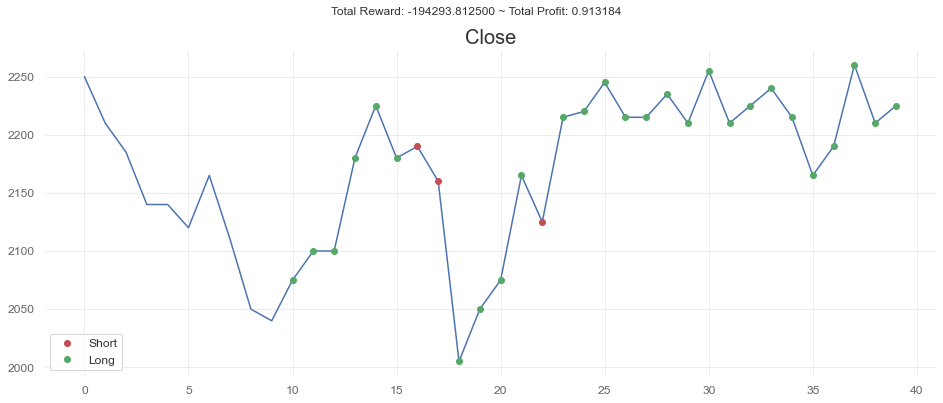

In [24]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


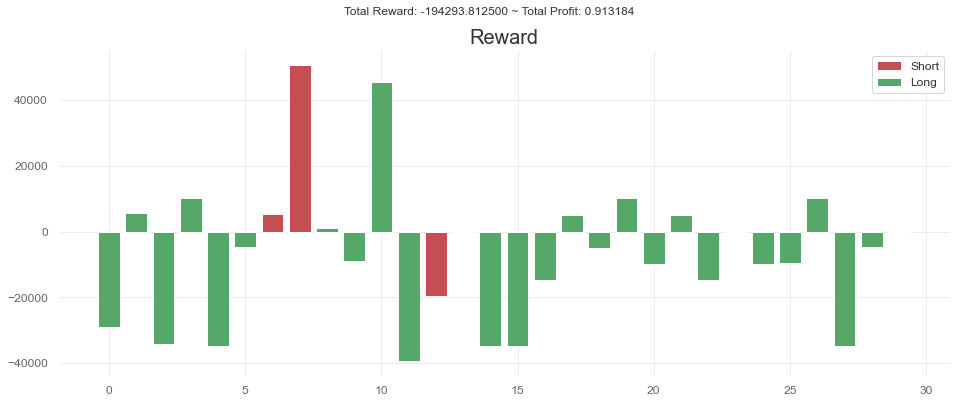

In [25]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


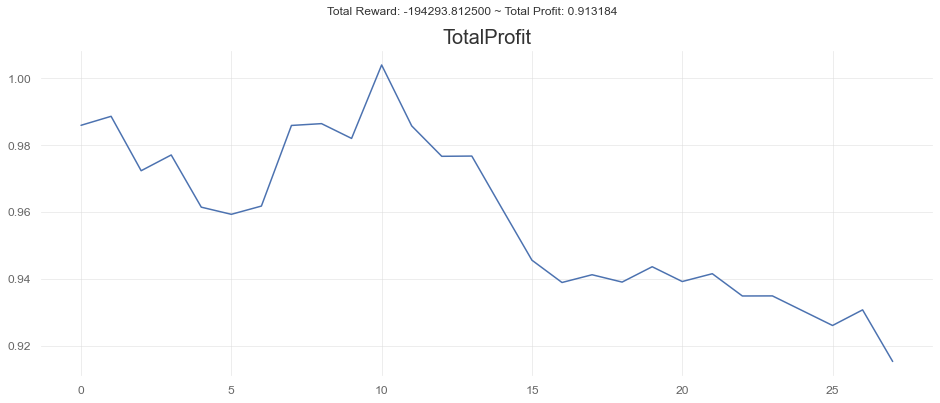

In [26]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [16]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)

目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數
注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]


第一個數字：大括號
第二個數字：有四個打橫
第三個數字：打橫入面有幾多個數字
(1, 4, 6)
[[[1 2 3 4 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]]] 

第一個數字：有幾多大組嘅數字
第二個數字：入面有幾多個小組
第三個數字：每個小組入面有幾多個數字
(4, 3, 2)
[[[1 2]
  [3 4]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]]
